<a href="https://colab.research.google.com/github/ZzangJay/team_project/blob/main/20221124_48%EC%8B%9C%EA%B0%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
#import tensorflow as tf 
import os
import sys
from datetime import datetime, timedelta
from tqdm.autonotebook import tqdm
import csv
import re
import gzip
import shutil
import pickle
import gzip

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [2]:
from google.colab import drive  # for colab
drive.mount('/content/gdrive/')  # for colab
cloud_directory = '/content/gdrive/MyDrive/mimiciv_unzip/'
os.listdir(cloud_directory) # for colab, check cloud directory mount

Mounted at /content/gdrive/


['CHANGELOG.txt',
 'LICENSE.txt',
 'SHA256SUMS.txt',
 'index.html',
 'icu',
 'hosp',
 'drop_2_chartevents.csv']

In [3]:
admission = pd.read_csv('/content/gdrive/MyDrive/mimiciv_unzip/hosp/admissions.csv', low_memory=False, dtype='str', keep_default_na=False)
patients = pd.read_csv('/content/gdrive/MyDrive/mimiciv_unzip/hosp/patients.csv', low_memory=False, dtype='str', keep_default_na=False)
diagnoses_icd = pd.read_csv('/content/gdrive/MyDrive/mimiciv_unzip/hosp/diagnoses_icd.csv', low_memory=False, dtype='str', keep_default_na=False)
icustays = pd.read_csv('/content/gdrive/MyDrive/mimiciv_unzip/icu/icustays.csv', low_memory=False, dtype='str', keep_default_na=False)
sepsis = pd.read_csv('/content/gdrive/MyDrive/mimiciv_der/sepsis3.csv', low_memory=False, dtype='str', keep_default_na=False)

In [4]:
admission = pd.merge(left = admission, right = sepsis[['subject_id','sepsis3']], how='inner', left_on='subject_id', right_on='subject_id')
patients = pd.merge(left = patients, right = sepsis[['subject_id','sepsis3']], how='inner', left_on='subject_id', right_on='subject_id')
diagnoses_icd = pd.merge(left = diagnoses_icd, right = sepsis[['subject_id','sepsis3']], how='inner', left_on='subject_id', right_on='subject_id')
sepsis = pd.merge(left = sepsis, right = icustays[['hadm_id','stay_id']], how='left', left_on='stay_id', right_on='stay_id')

In [35]:
# extra_features = pd.read_csv('/content/gdrive/MyDrive/mimiciv preprocessing_js/extra_features2.csv', low_memory=False, keep_default_na=False)
extra_features = pd.read_csv('/content/gdrive/MyDrive/mimiciv preprocessing_js/extra_features_1119.csv', low_memory=False, keep_default_na=False,index_col = False)
sepsis2 = pd.merge(left = sepsis, right = extra_features['hadm_id'].astype(str), how='inner', left_on='hadm_id', right_on='hadm_id')

In [14]:
sepsis2.head()

,subject_id,stay_id,antibiotic_time,culture_time,suspected_infection_time,sofa_time,sofa_score,respiration,coagulation,liver,cardiovascular,cns,renal,sepsis3,hadm_id
0,16266622,32828424,2134-09-20 16:00:00,2134-09-20 15:32:00,2134-09-20 15:32:00,2134-09-20 16:00:00,2,2,0,0,0,0,0,true,23933519
1,13830137,31445489,2174-05-06 22:00:00,2174-05-06 00:00:00,2174-05-06 00:00:00,2174-05-06 21:00:00,2,0,0,0,0,0,2,true,26514599
2,14367208,39300189,2135-09-14 18:00:00,2135-09-14 00:45:00,2135-09-14 00:45:00,2135-09-14 04:00:00,2,0,0,1,0,0,1,true,21036742
3,12035173,34909617,2168-01-25 02:00:00,2168-01-22 04:04:00,2168-01-22 04:04:00,2168-01-22 01:00:00,2,0,0,0,0,2,0,true,29109331
4,13729279,39470047,2181-01-14 04:00:00,2181-01-13 17:50:00,2181-01-13 17:50:00,2181-01-14 05:00:00,2,0,0,0,0,2,0,true,24054987


In [6]:
Total_HADMIDS = set(sepsis2['hadm_id'])
len(Total_HADMIDS)
# Total_HADMIDS = set(sepsis['hadm_id'])
# len(Total_HADMIDS)
#32812

32365

In [7]:
# feature_keys = ['FiO2', 'HR', 'PaO2', 'SBP', 'Temperature','Creatinine','Glucose', 'Hb', 'Lactate', 'Plt','Sodium' ,'WBC']
# feature_keys = ['FiO2', 'HR', 'PaO2', 'SBP', 'Temperature','Creatinine','Glucose', 'Hb', 'Lactate', 'Plt','Sodium' ,'WBC', 'DBP', 'MAP', 'RESP', 'Chloride', 'Hct', 'PCO2', 'Potassium', 'PH', 'Anion Gap', 'Bilirubin']
feature_keys = ['FiO2', 'HR', 'PaO2', 'SBP', 'Temperature','Creatinine','Glucose', 'Hb', 'Lactate', 'Plt','Sodium' ,'WBC', 'DBP', 'MAP', 'RESP', 'Chloride', 'Hct', 'PCO2', 'Potassium', 'PH', 'Anion Gap', 'Bilirubin']
print(len(feature_keys))

22


## 데이터 추출



In [8]:
EXTRACT_FEATURE_CODES_VS = dict({
    '226754': 'FiO2', '223835': 'FiO2', '227010': 'FiO2', '229280':'FiO2', '229841': 'FiO2',
    '220045': 'HR', '220046': 'HR', '226764': 'HR', '227018': 'HR',
    '220224': 'PaO2', '227039': 'PaO2', '227516': 'PaO2',
    '220050': 'SBP' ,'220179': 'SBP', '224167': 'SBP', '227243': 'SBP', '228152': 'SBP',
    '223762': 'Temperature', '226329': 'Temperature', '227632': 'Temperature', '227634': 'Temperature',
    '223761': 'TEMP_F',
    '225310': 'DBP', '220051': 'DBP', '220180': 'DBP',
    '225312': 'MAP', '220052': 'MAP', '220181': 'MAP',
    '220210': 'RESP', '224690': 'RESP'
    })
EXTRACT_FEATURE_CODES_LAB = dict({
    '220615': 'Creatinine', '229761': 'Creatinine',
    '52024': 'Creatinine', '50912': 'Creatinine', '52546': 'Creatinine', '51977': 'Creatinine',  '51081': 'Creatinine',
    '220621': 'Glucose', '225664': 'Glucose', '226537': 'Glucose',
    '50809': 'Glucose', '52027': 'Glucose', '50931': 'Glucose', '52569': 'Glucose', '51981': 'Glucose', '51478': 'Glucose',
    '220228': 'Hb',
    '50811': 'Hb', '50855': 'Hb', '51640': 'Hb', '51645': 'Hb', '51222': 'Hb', '52157': 'Hb',
    '225668': 'Lactate',
    '50813': 'Lactate', '52442': 'Lactate',
    '227457': 'Plt',
    '51704': 'Plt', '51265': 'Plt',
    '220645': 'Sodium', '226534': 'Sodium',
    '50824': 'Sodium', '52455': 'Sodium', '50983': 'Sodium', '52623': 'Sodium',
    '220546': 'WBC',
    '51755': 'WBC', '51756': 'WBC', '51301': 'WBC',
    '50805': 'Chloride', '50902': 'Chloride',
    '50810': 'Hct',
    '50810': 'PCO2',
    '50822': 'Potassium', '50971': 'Potassium',
    '50820': 'PH',
    '50868': 'Anion Gap',
    '50885': 'Bilirubin'
    }) 
EXTRACT_FEATURE_CODES_NORMAL = dict({
        'FiO2': [10, 100],
        'HR': [30, 200],
        'PaO2': [50, 200],
        'SBP': [40, 250],
        'Temperature': [30, 45],
        'Creatinine': [0.2, 100],
        'Glucose': [30, 1000],
        'Hb': [5, 20],
        'Lactate': [0.5, 2.5],
        'Plt': [10, 500],
        'Sodium': [90, 170],
        'WBC': [1, 30],
        'DBP':[30,200],
        'MAP':[33,216],
        'RESP':[0,35],
        'Chloride':[70,130],
        'Hct':[10,50],
        'PCO2':[5,100],
        'Potassium':[1.0,10.0],
        'PH':[5.5,8.0],
        'Anion Gap':[5,50],
        'Bilirubin':[0.1,10]
})
NORMAL_VALUE = dict({
        'FiO2': 40,
        'HR': 75, #(50+100)/2
        'PaO2': 87.5, #(75+100)/2
        'SBP': 115, #(90+140)/2 = 115
        'Temperature': 36.65, #(36.1+37.2)/2
        'Creatinine': 1.0, #(0.7+1.0)/2
        'Glucose': 100, #(60+140)/2
        'Hb': 15.0, #(13.8+17.2)/2
        'Lactate': 1.35, #(0.5+2.2)/2 = 1.35
        'Plt': 270, #(140+400)/2
        'Sodium': 140, #(135+145)/2
        'WBC': 7.5, #(5+10)/2
        'DBP': 90, #(80+100)/2 
        'MAP': 98, # (115 + 2*90) / 
        'RESP': 13, 
        'Chloride': 102, #(96+108) / 2
        'Hct': 34.5, #(34+45)/2
        'PCO2': 40, #(35+45)/2
        'Potassium': 4.5, #(3.5+5.4)/2
        'PH': 7.4, #(7.35 + 7.45) / 2
        'Anion Gap': 14, #8+20/2
        'Bilirubin': 0.8 #0+1.5/2
})

# EXTRACT_FEATURE_CODES_anti = ('225798','225837','225838','225840','225842','225843','225844','225845','225847','225848','225850','225851','225853','225855','225857','225859','225860','225862','225863','225865','225866','225868','225869','225871','225873','225875','225876','225877','225879','225881','225882','225883','225884','225885','225886','225888','225889','225890','225892','225893','225895','225896','225897','225898','225899','225900','225902','225903','225905','227691','228003','229059','229061','229064','229587')
# EXTRACT_FEATURE_CODES_ANTI_2 = dict({
#    '225850': 'Cephalosporin', '225851': 'Cephalosporin', '225853': 'Cephalosporin', '225855': 'Cephalosporin', '229587':'Cephalosporin',
#    '225798': 'Glycopetide',
#    '225842': 'Penicillin', '225843': 'Penicillin', '225888': 'Penicillin', '225889': 'Penicillin', '225890': 'Penicillin', '225892': 'Penicillin', '225893': 'Penicillin',
#    '225859': 'Quninolone', '225859': 'Quninolone', '225879': 'Quninolone', '225886': 'Quninolone',
#    '225845': 'Macrolide', '225865': 'Macrolide', '225866': 'Macrolide'
# })

In [9]:
## Define some util functions
NOT_CONVERTED = 'NOT_CONVERTED'
## 문자로 기록된 날짜 값들을 파이썬의 datetime 데이터로 바꿔주는 함수 작성
def str2datetime(s):
    def _convert(_s, _dformat):
        try:
            converted_dt = datetime.strptime(_s, _dformat)
        except Exception:
            return NOT_CONVERTED

        return converted_dt

    if isinstance(s, datetime):
        return s

    dformats = [
        '%Y-%m-%d %p %I:%M:%S',
        '%Y-%m-%d %H:%M:%S.%f',
        '%Y-%m-%d %H:%M:%S',
        '%Y-%m-%d %H:%M',
        '%y-%m-%d %H:%M',
        '%Y-%m-%d',
        '%Y%m%d',
        '%Y-%m-%d +%H:%M',
        '%Y%m%d %H%M',
        '%Y%m%d%H%M%S',
        ]

    s = s.split('.')[0]
    s = s.replace('오전', 'am').replace('오후', 'pm')
    for dformat in dformats:
        dt = _convert(s, dformat)
        if dt != NOT_CONVERTED:
            return dt

    return NOT_CONVERTED

In [ ]:
def extract_features():
  features_hadm_id = dict()
  chartevents = csv.DictReader(open('/content/gdrive/MyDrive/mimiciv_unzip/icu/chartevents.csv', 'r', encoding='utf-8'))
  labevents = csv.DictReader(open('/content/gdrive/MyDrive/mimiciv_unzip/hosp/labevents.csv', 'r', encoding='utf-8'))
  for row in tqdm(chartevents, desc='Extract_VS', ncols=700):
    if row['hadm_id'] in Total_HADMIDS:
      hadm_id = row['hadm_id']
      features_hadm_id[hadm_id] = features_hadm_id.get(hadm_id, dict()) #get 없으면 2번째로 return

      item_id = row['itemid']
      if item_id not in EXTRACT_FEATURE_CODES_VS:
        continue
      item_name = EXTRACT_FEATURE_CODES_VS[item_id]
      try:
        #정규식을 이용해서 기록된 값에서 숫자 형태의 값만 가져오기
        #소수점 둘째자리 까지만 값을 사용하기
        item_value = round(float(re.findall("\d+\.\d+|\d+", row['valuenum'])[0]), 2)
      except Exception:
        continue
      
      item_time = str2datetime(row['charttime'])
      if item_time == NOT_CONVERTED:
        continue
      #GCP total score도 시간대에 총합으로 사용함
      if item_name == 'TEMP_F':
        item_value = round((item_value - 32.0) / 1.8, 2)
        item_name = 'TEMP'

    #   if item_value > FEATURE_NORMAL_RANGE[item_name][1]:
    #     item_value = FEATURE_NORMAL_RANGE[item_name][1]
    #   elif item_value < FEATURE_NORMAL_RANGE[item_name][0]:
    #     item_value = FEATURE_NORMAL_RANGE[item_name][0]

      features_hadm_id[hadm_id][item_name] = features_hadm_id[hadm_id].get(item_name, list()) #같은 환자의 여러개 feature가 있으면 list로 반환하도록
      features_hadm_id[hadm_id][item_name].append((item_time, item_value))
      
    else:
      continue

  for row in tqdm(labevents, desc='Extract_LAB', ncols=700):
    if row['hadm_id'] in Total_HADMIDS:
      hadm_id = row['hadm_id']
      features_hadm_id[hadm_id] = features_hadm_id.get(hadm_id, dict())

      item_id = row['itemid']
      if item_id not in EXTRACT_FEATURE_CODES_LAB:
        continue
      item_name = EXTRACT_FEATURE_CODES_LAB[item_id]
      try:
        #정규식을 이용해서 기록된 값에서 숫자 형태의 값만 가져오기
        #소수점 둘째자리 까지만 값을 사용하기
        item_value = round(float(re.findall("\d+\.\d+|\d+", row['valuenum'])[0]), 2)
      except Exception:
        continue
      
      item_time = str2datetime(row['charttime'])
      if item_time == NOT_CONVERTED:
        continue

      #if item_value > FEATURE_NORMAL_RANGE[item_name][1]:
      #  item_value = FEATURE_NORMAL_RANGE[item_name][1]
      #elif item_value < FEATURE_NORMAL_RANGE[item_name][0]:
      #  item_value = FEATURE_NORMAL_RANGE[item_name][0]
        
      features_hadm_id[hadm_id][item_name] = features_hadm_id[hadm_id].get(item_name, list())
      features_hadm_id[hadm_id][item_name].append((item_time, item_value))
      
    else:
      continue
      
  return features_hadm_id

In [ ]:
# extracted_features = extract_features()

Extract_VS:   0%|                                                                                             …

Extract_LAB:   0%|                                                                                            …

In [ ]:
# with gzip.open('/content/gdrive/MyDrive/sepsis_model_weight/extracted_features_20221108.pickle', 'wb') as f:
#     pickle.dump(extracted_features, f)

In [ ]:
# with gzip.open('/content/gdrive/MyDrive/sepsis_model_weight/extracted_features_20221108.pickle','rb') as f:
#     extracted_features = pickle.load(f)

In [15]:
with gzip.open('/content/gdrive/MyDrive/sepsis_model_weight/extracted_features_1112.pickle','rb') as f:
    extracted_features = pickle.load(f)

In [16]:
extra_features.columns

Index(['hadm_id', 'weight', 'age', 'insurance', 'gender',
       'race_AMERICAN INDIAN/ALASKA NATIVE', 'race_ASIAN',
       'race_ASIAN - ASIAN INDIAN', 'race_ASIAN - CHINESE',
       'race_ASIAN - KOREAN', 'race_ASIAN - SOUTH EAST ASIAN',
       'race_BLACK/AFRICAN', 'race_BLACK/AFRICAN AMERICAN',
       'race_BLACK/CAPE VERDEAN', 'race_BLACK/CARIBBEAN ISLAND',
       'race_HISPANIC OR LATINO', 'race_HISPANIC/LATINO - CENTRAL AMERICAN',
       'race_HISPANIC/LATINO - COLUMBIAN', 'race_HISPANIC/LATINO - CUBAN',
       'race_HISPANIC/LATINO - DOMINICAN', 'race_HISPANIC/LATINO - GUATEMALAN',
       'race_HISPANIC/LATINO - HONDURAN', 'race_HISPANIC/LATINO - MEXICAN',
       'race_HISPANIC/LATINO - PUERTO RICAN',
       'race_HISPANIC/LATINO - SALVADORAN', 'race_MULTIPLE RACE/ETHNICITY',
       'race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'race_OTHER',
       'race_PATIENT DECLINED TO ANSWER', 'race_PORTUGUESE',
       'race_SOUTH AMERICAN', 'race_UNABLE TO OBTAIN', 'race_UNKNOWN',
  

In [36]:
extra_features.set_index('hadm_id', drop=True, append=False, inplace=True, verify_integrity=False)
extra_features=extra_features[['weight','age','gender','insurance','race_ASIAN','race_BLACK/AFRICAN','race_HISPANIC OR LATINO','race_WHITE']]
extra_features

,weight,age,gender,insurance,race_ASIAN,race_BLACK/AFRICAN,race_HISPANIC OR LATINO,race_WHITE
hadm_id,,,,,,,,
20000147,0.650667,0.71,1,1,0,0,0,0
20000298,0.520000,0.79,0,1,0,1,0,0
20000374,0.573333,0.35,1,1,0,0,0,0
20000535,0.500000,0.59,1,2,0,0,0,1
20000600,0.580667,0.59,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...
29999415,0.353333,0.55,0,1,0,0,0,1
29999444,0.613333,0.59,0,1,0,0,0,1
29999457,0.772000,0.62,1,2,0,0,0,1


In [18]:
# 사망 레이블 하기
death_labels = dict()
admissions = csv.DictReader(open('/content/gdrive/MyDrive/mimiciv_der/sepsis3_admissions.csv', 'r', encoding='utf-8'))
for row in tqdm(admissions, desc='Get Death Label'):
  hadm_id = row['hadm_id']
  death_yn = int(row['hospital_expire_flag'])
  if death_yn:
    event_time = str2datetime(row['deathtime'])
  else:
    event_time = str2datetime(row['dischtime'])
  death_labels[hadm_id] = dict({'DEATH': death_yn, 'EVENT_TIME': event_time})

Get Death Label: 0it [00:00, ?it/s]

In [19]:
## 환자의 입실 퇴실 시간 정보 가져오기
Extracted_HADMIDS = list(extracted_features.keys())
admin_disc_time = dict()

admissions = csv.DictReader(open('/content/gdrive/MyDrive/mimiciv_der/sepsis3_admissions.csv', 'r', encoding='utf-8'))
for row in admissions:
  hadm_id = row['hadm_id']
  admin_time = str2datetime(row['admittime'])
  disc_time = str2datetime(row['dischtime'])

  if (admin_time != NOT_CONVERTED) and (disc_time != NOT_CONVERTED):
    admin_disc_time[hadm_id] = dict({'ADMIN': admin_time, 'DISC': disc_time})

In [20]:
## 입실 시점으로부터 1시간 간격으로 데이터를 읽어오는 함수 정의
def quantize_features(feature_list, admin_time, disc_time, missing_feature=False):
  total_hours = int((disc_time - admin_time).total_seconds() / (60*60))
  #입실 이후 최대 24시간 동안의 데이터만 가져오기
  if total_hours > 48:
    total_hours = 48
#   if total_hours > 24:
#     total_hours = 24
  
  quantized_features = list()
  if missing_feature:
    for i in range(total_hours):
      quantized_time = admin_time + timedelta(hours=i)
      quantized_value = np.nan #지금은 dic 형태라, pandas 쓰면 NAN이랑 동일, carry forward 도 가능
      quantized_features.append((quantized_time, quantized_value))
  else:
    feature_list = list(sorted(feature_list, key=lambda x: x[0]))
    for i in range(total_hours):
      quantized_time = admin_time + timedelta(hours=i)
      quantized_time_start = quantized_time - timedelta(hours=1)
      quantized_values = list(filter(lambda x: quantized_time_start < x[0] <= quantized_time, feature_list)) #filter함수 True만 필터
      if len(quantized_values) > 0:
        quantized_value = quantized_values[-1][1]
      else:
        quantized_value = np.nan 

      quantized_features.append((quantized_time, quantized_value))
  
  return quantized_features

In [21]:
## 전체 데이터에 대해서 데이터 변환하기
quantized_features = dict()
for hadm_id in tqdm(Extracted_HADMIDS, desc='Doing Quantization'):
    admin_time = admin_disc_time[hadm_id]['ADMIN']
    disc_time = admin_disc_time[hadm_id]['DISC']
    if (disc_time - admin_time).total_seconds() / (60*60) < 1.0:
      continue
    quantized_features[hadm_id] = dict()
    for kk in feature_keys:
      if kk in extracted_features[hadm_id]:
        feature_list = extracted_features[hadm_id][kk]
        quantized_features[hadm_id][kk] = quantize_features(feature_list, admin_time, disc_time)
      else:
        quantized_features[hadm_id][kk] = quantize_features(None, admin_time, disc_time, missing_feature=True)

Doing Quantization:   0%|          | 0/32365 [00:00<?, ?it/s]

In [22]:
def carry_forward(feature_name, feature_list):
  imputed_features = list()
  for i, (feature_t, feature_v) in enumerate(feature_list):
    if np.isnan(feature_v):
      last_observations = list(filter(lambda x: (x[0] <= feature_t) and (not np.isnan(x[1])), feature_list))
      if len(last_observations) > 0:
        imputed_features.append((feature_t, last_observations[-1][1]))
      else:
        imputed_features.append((feature_t, NORMAL_VALUE[feature_name]))
    else:
      imputed_features.append((feature_t, feature_v))

  return imputed_features

In [23]:
Quantized_HADMIDS = list(quantized_features.keys())
carry_forwarded_features = dict()
for hadm_id in tqdm(Quantized_HADMIDS, desc='Carry-Forward'):
  carry_forwarded_features[hadm_id] = dict()

  for kk in feature_keys:
    feature_list = quantized_features[hadm_id][kk]
    carry_forwarded_features[hadm_id][kk] = carry_forward(kk, feature_list)

Carry-Forward:   0%|          | 0/32340 [00:00<?, ?it/s]

In [24]:
#Min-Max Normalization
min_max_normalized = dict()
for hadm_id in tqdm(Quantized_HADMIDS, desc='Min-Max Normalization', ncols=700):
  min_max_normalized[hadm_id] = dict()
  for kk in feature_keys:
    features = np.array(carry_forwarded_features[hadm_id][kk])

    min = EXTRACT_FEATURE_CODES_NORMAL[kk][0]
    max = EXTRACT_FEATURE_CODES_NORMAL[kk][1]

    features[:, 1] = (features[:, 1] - min) / (max - min)
    min_max_normalized[hadm_id][kk] = features

Min-Max Normalization:   0%|                                                                                  …

## 데이터 준비

In [25]:
total_death_included_hadm_ids = list(death_labels.keys())
#total_los_included_hadm_ids = list(los_labels.keys())

In [30]:
death_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list(),
    'EXTRA' : list(),
})

for hadm_id in tqdm(total_death_included_hadm_ids, desc='Make Death Dataset', ncols=700):
  if hadm_id not in min_max_normalized:
    continue
  if len(min_max_normalized[hadm_id][feature_keys[0]]) >= 48:
    time_len = 48
  else:
    time_len = len(min_max_normalized[hadm_id][feature_keys[0]])
  
  try:
    data = np.array(min_max_normalized[hadm_id][feature_keys[0]])[:time_len, 1].reshape(time_len, 1)
  except:
    continue

  for kk in feature_keys[1:]:
    data = np.concatenate((data, np.array(min_max_normalized[hadm_id][kk])[:time_len, 1].reshape(time_len, 1)), axis=1)
  
  death_dataset['HADM_IDS'].append(hadm_id)
  death_dataset['LABEL'].append(death_labels[hadm_id]['DEATH'])
  death_dataset['DATA'].append(data)

# 추가 feature 입력
if type(extra_features) is np.ndarray : 
    pass
else :
  extra_features=extra_features.reindex(pd.to_numeric(death_dataset['HADM_IDS']))
  extra_features=np.array(extra_features)

for ef in tqdm(extra_features, desc='+ Extra_features', ncols=700):
  death_dataset['EXTRA'].append(ef)

Make Death Dataset:   0%|                                                                                     …

AttributeError: ignored

In [38]:
id_cepha = pd.read_csv('/content/gdrive/MyDrive/mimiciv_der/temp/id_cepha.csv', low_memory=False, dtype='str', keep_default_na=False)
id_glyco = pd.read_csv('/content/gdrive/MyDrive/mimiciv_der/temp/id_glyco.csv', low_memory=False, dtype='str', keep_default_na=False)
id_peni = pd.read_csv('/content/gdrive/MyDrive/mimiciv_der/temp/id_peni.csv', low_memory=False, dtype='str', keep_default_na=False)
id_fluoro = pd.read_csv('/content/gdrive/MyDrive/mimiciv_der/temp/id_fluoro.csv', low_memory=False, dtype='str', keep_default_na=False)
id_macro = pd.read_csv('/content/gdrive/MyDrive/mimiciv_der/temp/id_macro.csv', low_memory=False, dtype='str', keep_default_na=False)
id_cepha['LABEL'] = "cepha"
id_glyco['LABEL'] = "glyco"
id_peni['LABEL'] = "peni"
id_fluoro['LABEL'] = "fluoro"
id_macro['LABEL'] = "macro"
id = pd.concat([id_cepha,id_glyco,id_peni,id_fluoro,id_macro])

In [39]:
# 항생제 레이블 하기
anti_labels = dict()
for row in list(set(id['hadm_id'])):
    hadm_id = row
    anti_1 = 0
    anti_2 = 0
    anti_3 = 0
    anti_4 = 0
    anti_5 = 0
    temp = id[id['hadm_id']==row]
    temp = temp.groupby(['LABEL']).count()
    if 'cepha' in temp.iloc[:,0] : 
        anti_1 = 1
    if 'glyco' in temp.iloc[:,0] :
        anti_2 = 1
    if 'peni' in temp.iloc[:,0] :
        anti_3 = 1
    if 'fluoro' in temp.iloc[:,0] :
        anti_4 = 1
    if 'macro' in temp.iloc[:,0] :
        anti_5 = 1
    anti_labels[hadm_id] = dict({'cepha': anti_1, 'glyco':anti_2, 'peni':anti_3, 'fluoro':anti_4, 'macro':anti_5})

In [40]:
#항생제용 데이터
anti_dataset = dict({
    'HADM_IDS': list(),
    'LABEL_1': list(),
    'LABEL_2': list(),
    'LABEL_3': list(),
    'LABEL_4': list(),
    'LABEL_5': list(),
    'DATA': list(),
    'EXTRA' : list()
})

for hadm_id in tqdm(total_death_included_hadm_ids, desc='Make anti Dataset', ncols=700):
  if hadm_id not in min_max_normalized:
    continue
  if len(min_max_normalized[hadm_id][feature_keys[0]]) >= 24:
    time_len = 24
  else:
    time_len = len(min_max_normalized[hadm_id][feature_keys[0]])
  
  try:
    data = np.array(min_max_normalized[hadm_id][feature_keys[0]])[:time_len, 1].reshape(time_len, 1)
  except:
    continue

  for kk in feature_keys[1:]:
    data = np.concatenate((data, np.array(min_max_normalized[hadm_id][kk])[:time_len, 1].reshape(time_len, 1)), axis=1)
  
  anti_dataset['HADM_IDS'].append(hadm_id)
  try :
      anti_dataset['LABEL_1'].append(anti_labels[hadm_id]['cepha'])
  except : 
      anti_dataset['LABEL_1'].append(0)
  try :
      anti_dataset['LABEL_2'].append(anti_labels[hadm_id]['glyco'])
  except : 
      anti_dataset['LABEL_2'].append(0)
  try :
      anti_dataset['LABEL_3'].append(anti_labels[hadm_id]['peni'])
  except : 
      anti_dataset['LABEL_3'].append(0)
  try :
      anti_dataset['LABEL_4'].append(anti_labels[hadm_id]['fluoro'])
  except : 
      anti_dataset['LABEL_4'].append(0)
  try :
      anti_dataset['LABEL_5'].append(anti_labels[hadm_id]['macro'])
  except : 
      anti_dataset['LABEL_5'].append(0)

  anti_dataset['DATA'].append(data)

# 추가 feature 입력
if type(extra_features) is np.ndarray : 
    pass
else :
    extra_features=extra_features.reindex(pd.to_numeric(anti_dataset['HADM_IDS']))
    extra_features=np.array(extra_features)

for ef in tqdm(extra_features, desc='+ Extra_features', ncols=700):
  anti_dataset['EXTRA'].append(ef)

print(len(anti_dataset['HADM_IDS']))

Make anti Dataset:   0%|                                                                                      …

+ Extra_features:   0%|                                                                                       …

32340


In [41]:
with gzip.open('/content/gdrive/MyDrive/sepsis_model_weight/20221124_death_dataset_plus_48.pickle', 'wb') as f:
    pickle.dump(death_dataset, f)
with gzip.open('/content/gdrive/MyDrive/sepsis_model_weight/20221124_anti_dataset_plus_48.pickle', 'wb') as f:
    pickle.dump(anti_dataset, f)

## 저장한 데이터셋 불러오기 

In [ ]:
with gzip.open('/content/gdrive/MyDrive/sepsis_model_weight/20221124_death_dataset_plus_48.pickle','rb') as f:
     death_dataset = pickle.load(f)
with gzip.open('/content/gdrive/MyDrive/sepsis_model_weight/20221124_anti_dataset_plus_48.pickle','rb') as f:
     anti_dataset = pickle.load(f)

## valid set 분할

In [42]:
temp = np.array(death_dataset['HADM_IDS'])
valid_idx_1 = np.where(temp == '22764516')[0].tolist()
valid_idx_2 = (np.where(temp == '20462195')[0].tolist())
valid_idx_3 = (np.where(temp == '26543049')[0].tolist())
valid_idx_4 = (np.where(temp == '21311611')[0].tolist())
valid_idx_5 = (np.where(temp == '23869046')[0].tolist())

print(valid_idx_1,valid_idx_2,valid_idx_3,valid_idx_4,valid_idx_5)

[16054] [6908] [18043] [30042] [2206]


In [43]:
def valid_set(dataset, many=True):
    idx = np.ones(len(death_dataset['HADM_IDS']),dtype=bool)
    valid_idx = [16054, 6908, 18043, 30042, 2206]
    idx[np.array(valid_idx)]=False

    if many :
        valid_set = dict({
            'HADM_IDS': np.array(dataset['HADM_IDS'])[valid_idx],
            'LABEL': np.array(dataset['LABEL'])[valid_idx],
            'DATA': np.array(dataset['DATA'])[valid_idx],
            'EXTRA': np.array(dataset['EXTRA'])[valid_idx].reshape((-1,8))
        })
        dataset_out = dict({
            'HADM_IDS': np.array(dataset['HADM_IDS'])[idx],
            'LABEL': np.array(dataset['LABEL'])[idx],
            'DATA': np.array(dataset['DATA'])[idx],
            'EXTRA': np.array(dataset['EXTRA'])[idx].reshape((-1,8))
        })
    else :
        valid_set = dict({
        'HADM_IDS': np.array(dataset['HADM_IDS'])[valid_idx],
        'LABEL_1': np.array(dataset['LABEL_1'])[valid_idx],
        'LABEL_2': np.array(dataset['LABEL_2'])[valid_idx],
        'LABEL_3': np.array(dataset['LABEL_3'])[valid_idx],
        'LABEL_4': np.array(dataset['LABEL_4'])[valid_idx],
        'LABEL_5': np.array(dataset['LABEL_5'])[valid_idx],
        'DATA': np.array(dataset['DATA'])[valid_idx],
        'EXTRA': np.array(dataset['EXTRA'])[valid_idx].reshape((-1,8))
        })

        dataset_out = dict({
        'HADM_IDS': np.array(dataset['HADM_IDS'])[idx],
        'LABEL_1': np.array(dataset['LABEL_1'])[idx],
        'LABEL_2': np.array(dataset['LABEL_2'])[idx],
        'LABEL_3': np.array(dataset['LABEL_3'])[idx],
        'LABEL_4': np.array(dataset['LABEL_4'])[idx],
        'LABEL_5': np.array(dataset['LABEL_5'])[idx],
        'DATA': np.array(dataset['DATA'])[idx],
        'EXTRA': np.array(dataset['EXTRA'])[idx].reshape((-1,8))
        })

    return valid_set, dataset_out

In [44]:
death_valid, death_dataset_out = valid_set(death_dataset)
anti_valid, anti_dataset_out = valid_set(anti_dataset,many=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you me

In [45]:
print(len(death_valid['HADM_IDS']))
print(len(death_dataset_out['HADM_IDS']))
print(len(anti_valid['HADM_IDS']))
print(len(anti_dataset_out['HADM_IDS']))

print(death_valid['LABEL'])
print(anti_valid['LABEL_1'])
print(anti_valid['LABEL_2'])
print(anti_valid['LABEL_3'])
print(anti_valid['LABEL_4'])
print(anti_valid['LABEL_5'])

5
32335
5
32335
[0 0 0 0 1]
[0 1 1 1 1]
[1 0 1 1 1]
[0 0 1 0 0]
[0 0 0 0 0]
[0 0 0 0 0]


## train-test 분할

In [46]:
## 학습용 검증용 데이터 나누기 (8:2)
def split_train_test(dataset, train_ratio=0.8, pos_neg=True):
  #레이블이 양성, 음성인 경우, 학습 데이터, 테스트 데이터를 나눌 때 
  #양성, 음성의 비율을 각각 유지할 수 있도록 구현
  if pos_neg:
    pos_idx = np.where(np.array(dataset['LABEL']) == 1)[0]
    neg_idx = np.where(np.array(dataset['LABEL']) == 0)[0]

    # suffle 넣어줘서 index 섞어줘야함. np.random, random,suffle
    np.random.shuffle(pos_idx)
    np.random.shuffle(neg_idx)

    pos_num = len(pos_idx)
    neg_num = len(neg_idx)

    train_pos_idx = list(pos_idx[:int(pos_num * train_ratio)])
    test_pos_idx = list(pos_idx[int(pos_num * train_ratio):])

    train_neg_idx = list(neg_idx[:int(neg_num * train_ratio)])
    test_neg_idx = list(neg_idx[int(neg_num * train_ratio):])

    train_idx = train_pos_idx + train_neg_idx
    test_idx = test_pos_idx + test_neg_idx
  
  #레이블이 양성, 음성이 아닌경우 단순하게 전체 데이터에서 학습, 테스트 비율만큼 나누기
  else:
    idx = np.arange(len(dataset['LABEL']))
    np.random.shuffle(idx)
    train_idx = idx[:int(len(idx) * train_ratio)]
    test_idx = idx[int(len(idx) * train_ratio):]

  train_set = dict({
      'HADM_IDS': np.array(dataset['HADM_IDS'])[train_idx],
      'LABEL': np.array(dataset['LABEL'])[train_idx],
      'DATA': np.array(dataset['DATA'])[train_idx],
       #'EXTRA': np.array(dataset['EXTRA'])[train_idx].reshape((-1,2))
      'EXTRA': np.array(dataset['EXTRA'])[train_idx].reshape((-1,8))
  })

  test_set = dict({
      'HADM_IDS': np.array(dataset['HADM_IDS'])[test_idx],
      'LABEL': np.array(dataset['LABEL'])[test_idx],
      'DATA': np.array(dataset['DATA'])[test_idx],
      #'EXTRA': np.array(dataset['EXTRA'])[test_idx].reshape((-1,2))
      'EXTRA': np.array(dataset['EXTRA'])[test_idx].reshape((-1,8))
  })
  return train_set, test_set

In [47]:
## 학습용 검증용 데이터 나누기 (8:2)
def split_train_test_many(dataset, train_ratio=0.8, pos_neg=True):
  #레이블이 양성, 음성인 경우, 학습 데이터, 테스트 데이터를 나눌 때 
  #양성, 음성의 비율을 각각 유지할 수 있도록 구현
  if pos_neg:
    # pos_idx = np.where(np.array(dataset['LABEL_1']) == 1)[0]
    # neg_idx = np.where(np.array(dataset['LABEL_1']) == 0)[0]

    # # suffle 넣어줘서 index 섞어줘야함. np.random, random,suffle
    # np.random.shuffle(pos_idx)
    # np.random.shuffle(neg_idx)

    # pos_num = len(pos_idx)
    # neg_num = len(neg_idx)

    # train_pos_idx = list(pos_idx[:int(pos_num * train_ratio)])
    # test_pos_idx = list(pos_idx[int(pos_num * train_ratio):])

    # train_neg_idx = list(neg_idx[:int(neg_num * train_ratio)])
    # test_neg_idx = list(neg_idx[int(neg_num * train_ratio):])

    # train_idx = train_pos_idx + train_neg_idx
    # test_idx = test_pos_idx + test_neg_idx
    pass
  #레이블이 양성, 음성이 아닌경우 단순하게 전체 데이터에서 학습, 테스트 비율만큼 나누기
  else:
    idx = np.arange(len(dataset['LABEL_1']))
    np.random.shuffle(idx)
    train_idx = idx[:int(len(idx) * train_ratio)]
    test_idx = idx[int(len(idx) * train_ratio):]

  train_set = dict({
      'HADM_IDS': np.array(dataset['HADM_IDS'])[train_idx],
      'LABEL_1': np.array(dataset['LABEL_1'])[train_idx],
      'LABEL_2': np.array(dataset['LABEL_2'])[train_idx],
      'LABEL_3': np.array(dataset['LABEL_3'])[train_idx],
      'LABEL_4': np.array(dataset['LABEL_4'])[train_idx],
      'LABEL_5': np.array(dataset['LABEL_5'])[train_idx],
      'DATA': np.array(dataset['DATA'])[train_idx],
      'EXTRA': np.array(dataset['EXTRA'])[train_idx].reshape((-1,8))
    #   'EXTRA': np.array(dataset['EXTRA'])[train_idx].reshape((-1,2))
  })

  test_set = dict({
      'HADM_IDS': np.array(dataset['HADM_IDS'])[test_idx],
      'LABEL_1': np.array(dataset['LABEL_1'])[test_idx],
      'LABEL_2': np.array(dataset['LABEL_2'])[test_idx],
      'LABEL_3': np.array(dataset['LABEL_3'])[test_idx],
      'LABEL_4': np.array(dataset['LABEL_4'])[test_idx],
      'LABEL_5': np.array(dataset['LABEL_5'])[test_idx],
      'DATA': np.array(dataset['DATA'])[test_idx],
      'EXTRA': np.array(dataset['EXTRA'])[test_idx].reshape((-1,8))
    #   'EXTRA': np.array(dataset['EXTRA'])[test_idx].reshape((-1,2))
  })
  return train_set, test_set

In [48]:
death_train, death_test = split_train_test(death_dataset_out)
anti_train, anti_test = split_train_test_many(anti_dataset_out, pos_neg=False)
#death_train, death_test = split_train_test(death_dataset)
#anti_train, anti_test = split_train_test_many(anti_dataset, pos_neg=False)
#los_train, los_test = split_train_test(los_dataset, pos_neg=False)

In [49]:
print(len(death_train['HADM_IDS']))
print(len(death_test['HADM_IDS']))
print(len(death_train['HADM_IDS'])/len(death_dataset_out['HADM_IDS']))
print(len(death_test['HADM_IDS'])/len(death_dataset_out['HADM_IDS']))


print(sum(death_dataset_out['LABEL']==1)/len(death_dataset_out['HADM_IDS']))
print(sum(death_train['LABEL']==1)/len(death_train['HADM_IDS']))
print(sum(death_test['LABEL']==1)/len(death_test['HADM_IDS']))
# print(len(los_train['HADM_IDS']))
# print(len(los_test['HADM_IDS']))

25868
6467
0.8
0.2
0.15664141023658573
0.15664141023658573
0.15664141023658573


In [50]:
print(len(anti_train['HADM_IDS']))
print(len(anti_test['HADM_IDS']))
print(len(anti_train['HADM_IDS'])/len(anti_dataset_out['HADM_IDS']))
print(len(anti_test['HADM_IDS'])/len(anti_dataset_out['HADM_IDS']))

print(sum(anti_train['LABEL_1']==1)/len(anti_train['HADM_IDS']))
print(sum(anti_test['LABEL_1']==1)/len(anti_test['HADM_IDS']))
print(sum(anti_train['LABEL_2']==1)/len(anti_train['HADM_IDS']))
print(sum(anti_test['LABEL_2']==1)/len(anti_test['HADM_IDS']))
print(sum(anti_train['LABEL_3']==1)/len(anti_train['HADM_IDS']))
print(sum(anti_test['LABEL_3']==1)/len(anti_test['HADM_IDS']))
print(sum(anti_train['LABEL_4']==1)/len(anti_train['HADM_IDS']))
print(sum(anti_test['LABEL_4']==1)/len(anti_test['HADM_IDS']))
print(sum(anti_train['LABEL_5']==1)/len(anti_train['HADM_IDS']))
print(sum(anti_test['LABEL_5']==1)/len(anti_test['HADM_IDS']))

25868
6467
0.8
0.2
0.333616823875058
0.34003401886500695
0.35387351167465597
0.36740374207515075
0.18733570434513686
0.1768980980361837
0.11021339106231638
0.11891139631977733
0.058953146745013146
0.056285758466058454


In [51]:
print(sum(anti_dataset_out['LABEL_1']==1)/len(anti_dataset_out['HADM_IDS']))
print(sum(anti_dataset_out['LABEL_2']==1)/len(anti_dataset_out['HADM_IDS']))
print(sum(anti_dataset_out['LABEL_3']==1)/len(anti_dataset_out['HADM_IDS']))
print(sum(anti_dataset_out['LABEL_4']==1)/len(anti_dataset_out['HADM_IDS']))
print(sum(anti_dataset_out['LABEL_5']==1)/len(anti_dataset_out['HADM_IDS']))

0.3349002628730478
0.3565795577547549
0.18524818308334623
0.11195299211380856
0.058419669089222206


## 모델 학습 


In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
from tensorflow.keras.utils import Sequence
import numpy as np

### 데이터 로더 생성하기

In [69]:
## 사망예측 모델용 데이터 로더_static 변수 추가
class Death_Dataloader2(Sequence):
    def __init__(self, x_set,x_set2, y_set, hadm_id_set, batch_size, shuffle=False):
        self.x, self.x2, self.y, self.hadm_id = x_set, x_set2, y_set, hadm_id_set
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

		# batch 단위로 직접 묶어줘야 함
    def __getitem__(self, idx):
		# sampler의 역할(index를 batch_size만큼 sampling해줌)
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        
        batch_x2 = [self.x2[i] for i in indices]

        ## 입력 데이터들의 크기를 최대 48시간으로 통일하고 48시간 보다 짧은 데이터들의 경우 끝에 '0' padding 붙이기
        padded_batch_x = np.zeros((len(batch_x), 48, len(feature_keys)))
        for i in range(len(batch_x)):
          valid_length = len(batch_x[i])
          padded_batch_x[i][:valid_length, :] = batch_x[i]
        

        batch_y = [self.y[i] for i in indices]
        batch_hadm_id = [self.hadm_id[i] for i in indices]

        return [np.array(padded_batch_x).astype('float32'), np.array(batch_x2).astype('float32')] ,np.array(batch_y).astype('float32')

    # epoch이 끝날때마다 실행
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [70]:
class Death_Dataloader_many(Sequence):
    def __init__(self, x_set,x_set2, y_set_1, y_set_2, y_set_3, y_set_4, y_set_5, hadm_id_set, batch_size, shuffle=False):
        self.x, self.x2, self.y_1, self.y_2, self.y_3, self.y_4, self.y_5, self.hadm_id = x_set, x_set2, y_set_1, y_set_2, y_set_3, y_set_4, y_set_5, hadm_id_set
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

		# batch 단위로 직접 묶어줘야 함
    def __getitem__(self, idx):
		# sampler의 역할(index를 batch_size만큼 sampling해줌)
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        
        batch_x2 = [self.x2[i] for i in indices]

        ## 입력 데이터들의 크기를 최대 48시간으로 통일하고 48시간 보다 짧은 데이터들의 경우 끝에 '0' padding 붙이기
        padded_batch_x = np.zeros((len(batch_x), 48, len(feature_keys)))
        for i in range(len(batch_x)):
          valid_length = len(batch_x[i])
          padded_batch_x[i][:valid_length, :] = batch_x[i]
        

        batch_y_1 = [self.y_1[i] for i in indices]
        batch_y_2 = [self.y_2[i] for i in indices]
        batch_y_3 = [self.y_3[i] for i in indices]
        batch_y_4 = [self.y_4[i] for i in indices]
        batch_y_5 = [self.y_5[i] for i in indices]
        batch_hadm_id = [self.hadm_id[i] for i in indices]

        return [np.array(padded_batch_x).astype('float32'), np.array(batch_x2).astype('float32')] ,[np.array(batch_y_1).astype('float32'),np.array(batch_y_2).astype('float32'),np.array(batch_y_3).astype('float32'),np.array(batch_y_4).astype('float32'),np.array(batch_y_5).astype('float32')]

    # epoch이 끝날때마다 실행
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)


In [71]:
death_train_loader = Death_Dataloader2(death_train['DATA'], death_train['EXTRA'], death_train['LABEL'], death_train['HADM_IDS'], 64, True)
death_test_loader = Death_Dataloader2(death_test['DATA'], death_test['EXTRA'], death_test['LABEL'], death_test['HADM_IDS'], 64, False)
anti_train_loader = Death_Dataloader_many(anti_train['DATA'], anti_train['EXTRA'], anti_train['LABEL_1'], anti_train['LABEL_2'],anti_train['LABEL_3'],anti_train['LABEL_4'],anti_train['LABEL_5'],anti_train['HADM_IDS'], 64, True)
anti_test_loader = Death_Dataloader_many(anti_test['DATA'], anti_test['EXTRA'], anti_test['LABEL_1'], anti_test['LABEL_2'],anti_test['LABEL_3'],anti_test['LABEL_4'],anti_test['LABEL_5'],anti_test['HADM_IDS'], 64, True)

In [ ]:
# death_train_loader = Death_Dataloader2(death_train['DATA'], death_train['EXTRA'], death_train['LABEL'], death_train['HADM_IDS'], 128, True)
# death_test_loader = Death_Dataloader2(death_test['DATA'], death_test['EXTRA'], death_test['LABEL'], death_test['HADM_IDS'], 128, False)
# anti_train_loader = Death_Dataloader_many(anti_train['DATA'], anti_train['EXTRA'], anti_train['LABEL_1'], anti_train['LABEL_2'],anti_train['LABEL_3'],anti_train['LABEL_4'],anti_train['LABEL_5'],anti_train['HADM_IDS'], 128, True)
# anti_test_loader = Death_Dataloader_many(anti_test['DATA'], anti_test['EXTRA'], anti_test['LABEL_1'], anti_test['LABEL_2'],anti_test['LABEL_3'],anti_test['LABEL_4'],anti_test['LABEL_5'],anti_test['HADM_IDS'], 128, True)

In [ ]:
# death_train_loader = Death_Dataloader2(death_train['DATA'], death_train['EXTRA'], death_train['LABEL'], death_train['HADM_IDS'], 512, True)
# death_test_loader = Death_Dataloader2(death_test['DATA'], death_test['EXTRA'], death_test['LABEL'], death_test['HADM_IDS'], 512, False)
# anti_train_loader = Death_Dataloader_many(anti_train['DATA'], anti_train['EXTRA'], anti_train['LABEL_1'], anti_train['LABEL_2'],anti_train['LABEL_3'],anti_train['LABEL_4'],anti_train['LABEL_5'],anti_train['HADM_IDS'], 512, True)
# anti_test_loader = Death_Dataloader_many(anti_test['DATA'], anti_test['EXTRA'], anti_test['LABEL_1'], anti_test['LABEL_2'],anti_test['LABEL_3'],anti_test['LABEL_4'],anti_test['LABEL_5'],anti_test['HADM_IDS'], 512, True)

## 항생제예측(심플한 모델)

In [ ]:
from keras import backend as k
k.clear_session()

In [ ]:
# lr_schedule2 = keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.02,decay_steps=10000)
# optimizer_cosine = keras.optimizers.SGD(learning_rate=lr_schedule2)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=100000,
    decay_rate=0.96)
optimizer_decay = keras.optimizers.SGD(learning_rate=lr_schedule)

In [ ]:
def lstm_model2():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.LSTM(32,return_sequences=True,activation='tanh')(input1)
  model1 = layers.LSTM(32,activation='tanh')(model1)
  model1 = layers.Dense(16)(model1)
  model1 = layers.Dropout(0.2)(model1)

  input2 = layers.Input(8)
  model2 = layers.Dense(16, activation='tanh')(input2)
  model2 = layers.Dropout(0.2)(model2)

  model_add = layers.Add()([model1, model2])
  model_add = layers.Dense(8)(model_add)
  output_1 = layers.Dense(1, activation='sigmoid', name='anti_1')(model_add)
  output_2 = layers.Dense(1, activation='sigmoid', name='anti_2')(model_add)
  output_3 = layers.Dense(1, activation='sigmoid', name='anti_3')(model_add)
  output_4 = layers.Dense(1, activation='sigmoid', name='anti_4')(model_add)
  output_5 = layers.Dense(1, activation='sigmoid', name='anti_5')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=[output_1, output_2, output_3, output_4, output_5])

  model.compile(optimizer = 'adam',loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  
  return model

In [ ]:
model2=lstm_model2()

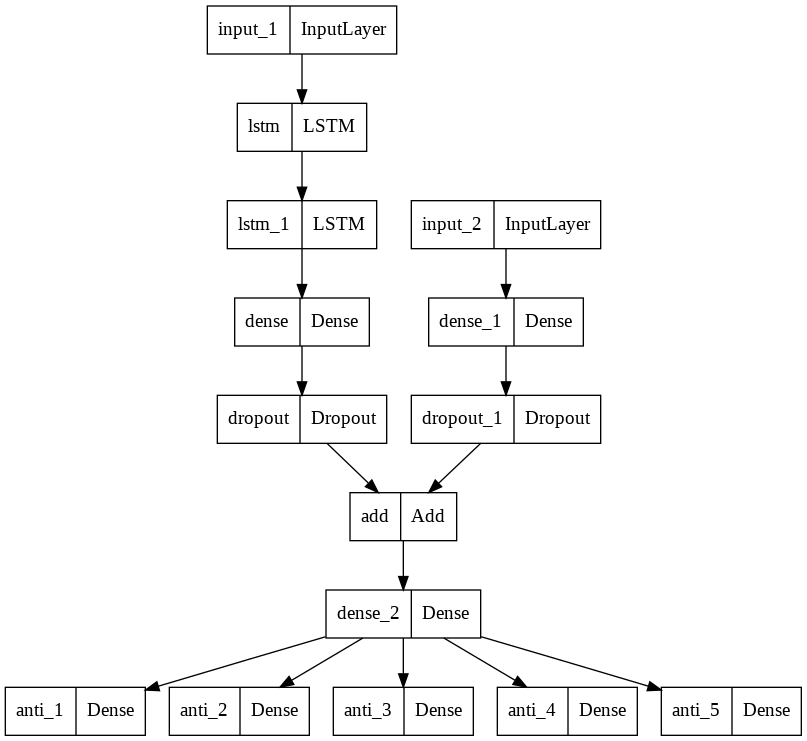

In [ ]:
from keras.utils import plot_model
plot_model(model2, to_file='./model.png')

Epoch 1/500
405/405 [==============================] - 23s 21ms/step - loss: 2.4456 - anti_1_loss: 0.6442 - anti_2_loss: 0.6737 - anti_3_loss: 0.5091 - anti_4_loss: 0.3743 - anti_5_loss: 0.2443 - anti_1_auc: 0.5396 - anti_2_auc_1: 0.5162 - anti_3_auc_2: 0.5184 - anti_4_auc_3: 0.5095 - anti_5_auc_4: 0.5090 - val_loss: 2.2935 - val_anti_1_loss: 0.6001 - val_anti_2_loss: 0.6457 - val_anti_3_loss: 0.4659 - val_anti_4_loss: 0.3600 - val_anti_5_loss: 0.2218 - val_anti_1_auc: 0.6493 - val_anti_2_auc_1: 0.5466 - val_anti_3_auc_2: 0.6024 - val_anti_4_auc_3: 0.5711 - val_anti_5_auc_4: 0.6329
Epoch 2/500
405/405 [==============================] - 7s 16ms/step - loss: 2.2931 - anti_1_loss: 0.6014 - anti_2_loss: 0.6511 - anti_3_loss: 0.4730 - anti_4_loss: 0.3478 - anti_5_loss: 0.2198 - anti_1_auc: 0.6405 - anti_2_auc_1: 0.5406 - anti_3_auc_2: 0.5987 - anti_4_auc_3: 0.5670 - anti_5_auc_4: 0.6033 - val_loss: 2.2780 - val_anti_1_loss: 0.5998 - val_anti_2_loss: 0.6433 - val_anti_3_loss: 0.4615 - val_an

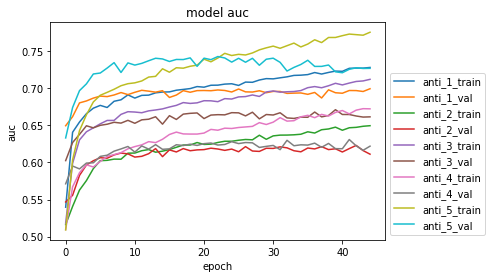

In [ ]:
from keras.utils import plot_model
plot_model(model2, to_file='./model.png')
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
            tf.keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/MyDrive/sepsis_model_weight/anti_model/lstm_model_many_simple.{epoch:02d}-{val_loss:.3f}.h5',save_best_only=True)]
history_lstm_simple = model2.fit(anti_train_loader,validation_data=anti_test_loader,epochs=500,callbacks=callback,batch_size=64)
from matplotlib import pyplot as plt
plt.plot(history_lstm_simple.history['anti_1_auc'])
plt.plot(history_lstm_simple.history['val_anti_1_auc'])
plt.plot(history_lstm_simple.history['anti_2_auc_1'])
plt.plot(history_lstm_simple.history['val_anti_2_auc_1'])
plt.plot(history_lstm_simple.history['anti_3_auc_2'])
plt.plot(history_lstm_simple.history['val_anti_3_auc_2'])
plt.plot(history_lstm_simple.history['anti_4_auc_3'])
plt.plot(history_lstm_simple.history['val_anti_4_auc_3'])
plt.plot(history_lstm_simple.history['anti_5_auc_4'])
plt.plot(history_lstm_simple.history['val_anti_5_auc_4'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['anti_1_train', 'anti_1_val','anti_2_train', 'anti_2_val','anti_3_train', 'anti_3_val','anti_4_train', 'anti_4_val','anti_5_train', 'anti_5_val'], loc='lower left',bbox_to_anchor=(1, 0))
plt.show()

In [ ]:
base_model = keras.models.load_model('/content/gdrive/MyDrive/sepsis_model_weight/anti_model/lstm_model_many_simple.25-2.189.h5')

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score, confusion_matrix

%matplotlib inline
lstm_train_predicts_1, lstm_test_predicts_1 = list(), list()
lstm_train_predicts_2, lstm_test_predicts_2 = list(), list()
lstm_train_predicts_3, lstm_test_predicts_3 = list(), list()
lstm_train_predicts_4, lstm_test_predicts_4 = list(), list()
lstm_train_predicts_5, lstm_test_predicts_5 = list(), list()
lstm_train_labels_1, lstm_test_labels_1 = list(), list()
lstm_train_labels_2, lstm_test_labels_2 = list(), list()
lstm_train_labels_3, lstm_test_labels_3 = list(), list()
lstm_train_labels_4, lstm_test_labels_4 = list(), list()
lstm_train_labels_5, lstm_test_labels_5 = list(), list()

for tr_x, tr_y in anti_train_loader:
    batch_predict = model2.predict(tr_x)
    lstm_train_predicts_1.append(batch_predict[0])
    lstm_train_predicts_2.append(batch_predict[1])
    lstm_train_predicts_3.append(batch_predict[2])
    lstm_train_predicts_4.append(batch_predict[3])
    lstm_train_predicts_5.append(batch_predict[4])
    lstm_train_labels_1.append(tr_y[0])
    lstm_train_labels_2.append(tr_y[1])
    lstm_train_labels_3.append(tr_y[2])
    lstm_train_labels_4.append(tr_y[3])
    lstm_train_labels_5.append(tr_y[4])

for test_x, test_y in anti_test_loader:
    batch_predict = model2.predict(test_x)
    lstm_test_predicts_1.append(batch_predict[0])
    lstm_test_predicts_2.append(batch_predict[1])
    lstm_test_predicts_3.append(batch_predict[2])
    lstm_test_predicts_4.append(batch_predict[3])
    lstm_test_predicts_5.append(batch_predict[4])
    lstm_test_labels_1.append(test_y[0])
    lstm_test_labels_2.append(test_y[1])
    lstm_test_labels_3.append(test_y[2])
    lstm_test_labels_4.append(test_y[3])
    lstm_test_labels_5.append(test_y[4])

lstm_train_predicts_1 = np.concatenate(lstm_train_predicts_1).reshape(-1, 1)
lstm_train_predicts_2 = np.concatenate(lstm_train_predicts_2).reshape(-1, 1)
lstm_train_predicts_3 = np.concatenate(lstm_train_predicts_3).reshape(-1, 1)
lstm_train_predicts_4 = np.concatenate(lstm_train_predicts_4).reshape(-1, 1)
lstm_train_predicts_5 = np.concatenate(lstm_train_predicts_5).reshape(-1, 1)
lstm_train_labels_1 = np.concatenate(lstm_train_labels_1).astype('int')
lstm_train_labels_2 = np.concatenate(lstm_train_labels_2).astype('int')
lstm_train_labels_3 = np.concatenate(lstm_train_labels_3).astype('int')
lstm_train_labels_4 = np.concatenate(lstm_train_labels_4).astype('int')
lstm_train_labels_5 = np.concatenate(lstm_train_labels_5).astype('int')
lstm_test_predicts_1 = np.concatenate(lstm_test_predicts_1).reshape(-1, 1)
lstm_test_predicts_2 = np.concatenate(lstm_test_predicts_2).reshape(-1, 1)
lstm_test_predicts_3 = np.concatenate(lstm_test_predicts_3).reshape(-1, 1)
lstm_test_predicts_4 = np.concatenate(lstm_test_predicts_4).reshape(-1, 1)
lstm_test_predicts_5 = np.concatenate(lstm_test_predicts_5).reshape(-1, 1)
lstm_test_labels_1 = np.concatenate(lstm_test_labels_1).astype('int')
lstm_test_labels_2 = np.concatenate(lstm_test_labels_2).astype('int')
lstm_test_labels_3 = np.concatenate(lstm_test_labels_3).astype('int')
lstm_test_labels_4 = np.concatenate(lstm_test_labels_4).astype('int')
lstm_test_labels_5 = np.concatenate(lstm_test_labels_5).astype('int')

lstm_train_roc_x_1, lstm_train_roc_y_1, _ = roc_curve(lstm_train_labels_1, lstm_train_predicts_1)
lstm_train_roc_x_2, lstm_train_roc_y_2, _ = roc_curve(lstm_train_labels_2, lstm_train_predicts_2)
lstm_train_roc_x_3, lstm_train_roc_y_3, _ = roc_curve(lstm_train_labels_3, lstm_train_predicts_3)
lstm_train_roc_x_4, lstm_train_roc_y_4, _ = roc_curve(lstm_train_labels_4, lstm_train_predicts_4)
lstm_train_roc_x_5, lstm_train_roc_y_5, _ = roc_curve(lstm_train_labels_5, lstm_train_predicts_5)
lstm_train_auroc_1 = roc_auc_score(lstm_train_labels_1, lstm_train_predicts_1)
lstm_train_auroc_2 = roc_auc_score(lstm_train_labels_2, lstm_train_predicts_2)
lstm_train_auroc_3 = roc_auc_score(lstm_train_labels_3, lstm_train_predicts_3)
lstm_train_auroc_4 = roc_auc_score(lstm_train_labels_4, lstm_train_predicts_4)
lstm_train_auroc_5 = roc_auc_score(lstm_train_labels_5, lstm_train_predicts_5)
lstm_test_roc_x_1, lstm_test_roc_y_1, _ = roc_curve(lstm_test_labels_1, lstm_test_predicts_1)
lstm_test_roc_x_2, lstm_test_roc_y_2, _ = roc_curve(lstm_test_labels_2, lstm_test_predicts_2)
lstm_test_roc_x_3, lstm_test_roc_y_3, _ = roc_curve(lstm_test_labels_3, lstm_test_predicts_3)
lstm_test_roc_x_4, lstm_test_roc_y_4, _ = roc_curve(lstm_test_labels_4, lstm_test_predicts_4)
lstm_test_roc_x_5, lstm_test_roc_y_5, _ = roc_curve(lstm_test_labels_5, lstm_test_predicts_5)
lstm_test_auroc_1 = roc_auc_score(lstm_test_labels_1, lstm_test_predicts_1)
lstm_test_auroc_2 = roc_auc_score(lstm_test_labels_2, lstm_test_predicts_2)
lstm_test_auroc_3 = roc_auc_score(lstm_test_labels_3, lstm_test_predicts_3)
lstm_test_auroc_4 = roc_auc_score(lstm_test_labels_4, lstm_test_predicts_4)
lstm_test_auroc_5 = roc_auc_score(lstm_test_labels_5, lstm_test_predicts_5)

1/1 [==============================] - 0s 20ms/step


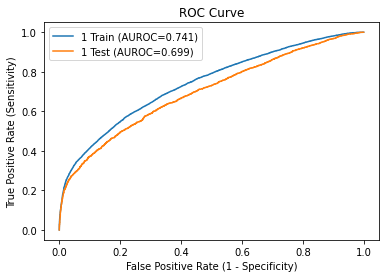

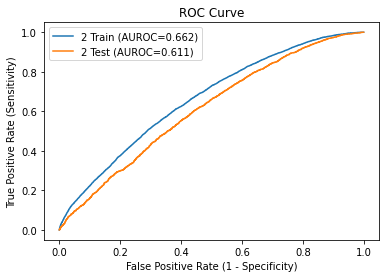

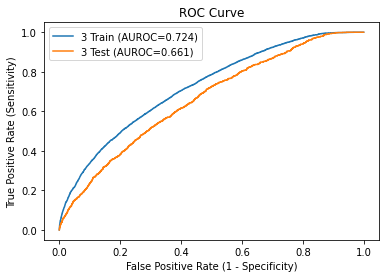

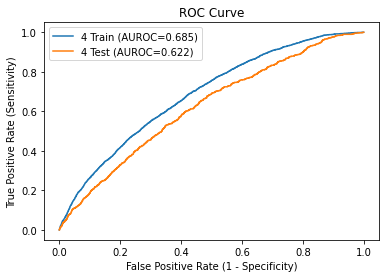

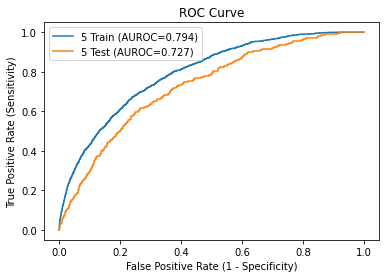

In [ ]:
plt.figure()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')

plt.plot(lstm_train_roc_x_1, lstm_train_roc_y_1, linewidth=1.5, label='{} (AUROC={:.3f})'.format('1 Train', lstm_train_auroc_1))
plt.plot(lstm_test_roc_x_1, lstm_test_roc_y_1, linewidth=1.5, label='{} (AUROC={:.3f})'.format('1 Test', lstm_test_auroc_1))

plt.legend(fancybox=True)

plt.show()

plt.figure()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')

plt.plot(lstm_train_roc_x_2, lstm_train_roc_y_2, linewidth=1.5, label='{} (AUROC={:.3f})'.format('2 Train', lstm_train_auroc_2))
plt.plot(lstm_test_roc_x_2, lstm_test_roc_y_2, linewidth=1.5, label='{} (AUROC={:.3f})'.format('2 Test', lstm_test_auroc_2))

plt.legend(fancybox=True)

plt.show()

plt.figure()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')

plt.plot(lstm_train_roc_x_3, lstm_train_roc_y_3, linewidth=1.5, label='{} (AUROC={:.3f})'.format('3 Train', lstm_train_auroc_3))
plt.plot(lstm_test_roc_x_3, lstm_test_roc_y_3, linewidth=1.5, label='{} (AUROC={:.3f})'.format('3 Test', lstm_test_auroc_3))

plt.legend(fancybox=True)

plt.show()

plt.figure()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')

plt.plot(lstm_train_roc_x_4, lstm_train_roc_y_4, linewidth=1.5, label='{} (AUROC={:.3f})'.format('4 Train', lstm_train_auroc_4))
plt.plot(lstm_test_roc_x_4, lstm_test_roc_y_4, linewidth=1.5, label='{} (AUROC={:.3f})'.format('4 Test', lstm_test_auroc_4))

plt.legend(fancybox=True)

plt.show()


plt.figure()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')

plt.plot(lstm_train_roc_x_5, lstm_train_roc_y_5, linewidth=1.5, label='{} (AUROC={:.3f})'.format('5 Train', lstm_train_auroc_5))
plt.plot(lstm_test_roc_x_5, lstm_test_roc_y_5, linewidth=1.5, label='{} (AUROC={:.3f})'.format('5 Test', lstm_test_auroc_5))

plt.legend(fancybox=True)

plt.show()

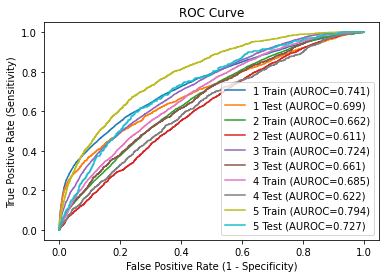

In [ ]:
plt.figure()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')

plt.plot(lstm_train_roc_x_1, lstm_train_roc_y_1, linewidth=1.5, label='{} (AUROC={:.3f})'.format('1 Train', lstm_train_auroc_1))
plt.plot(lstm_test_roc_x_1, lstm_test_roc_y_1, linewidth=1.5, label='{} (AUROC={:.3f})'.format('1 Test', lstm_test_auroc_1))
plt.plot(lstm_train_roc_x_2, lstm_train_roc_y_2, linewidth=1.5, label='{} (AUROC={:.3f})'.format('2 Train', lstm_train_auroc_2))
plt.plot(lstm_test_roc_x_2, lstm_test_roc_y_2, linewidth=1.5, label='{} (AUROC={:.3f})'.format('2 Test', lstm_test_auroc_2))
plt.plot(lstm_train_roc_x_3, lstm_train_roc_y_3, linewidth=1.5, label='{} (AUROC={:.3f})'.format('3 Train', lstm_train_auroc_3))
plt.plot(lstm_test_roc_x_3, lstm_test_roc_y_3, linewidth=1.5, label='{} (AUROC={:.3f})'.format('3 Test', lstm_test_auroc_3))
plt.plot(lstm_train_roc_x_4, lstm_train_roc_y_4, linewidth=1.5, label='{} (AUROC={:.3f})'.format('4 Train', lstm_train_auroc_4))
plt.plot(lstm_test_roc_x_4, lstm_test_roc_y_4, linewidth=1.5, label='{} (AUROC={:.3f})'.format('4 Test', lstm_test_auroc_4))
plt.plot(lstm_train_roc_x_5, lstm_train_roc_y_5, linewidth=1.5, label='{} (AUROC={:.3f})'.format('5 Train', lstm_train_auroc_5))
plt.plot(lstm_test_roc_x_5, lstm_test_roc_y_5, linewidth=1.5, label='{} (AUROC={:.3f})'.format('5 Test', lstm_test_auroc_5))

plt.legend(fancybox=True)

plt.show()

## 사망예측(항생제 예측 전이학습)

In [72]:
from keras import backend as k
k.clear_session()

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=100000,
    decay_rate=0.96)
optimizer_decay = keras.optimizers.SGD(learning_rate=lr_schedule)

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=100000,
    decay_rate=0.96)
optimizer_decay = keras.optimizers.SGD(learning_rate=lr_schedule)

### 다양한 모델 시도

In [ ]:
#@title temp

def lstm_bidirect3():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.Bidirectional(layers.LSTM(64,return_sequences=True))(input1)
  model1 = layers.Bidirectional(layers.LSTM(64))(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.2)(model1)
  model1 = layers.Dense(16)(model1)

  input2 = layers.Input(8)
  model2 = layers.Dense(64, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dense(32, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.2)(model2)
  model2 = layers.Dense(16)(model2)

  model_add = layers.Add()([model1, model2]) #concatonation 
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  #model_add = layers.Activation('relu')(model_add)
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  #model_add = layers.Activation('relu')(model_add)

  #output = layers.Dense(1, activation='sigmoid')(model_add)
  output_1 = layers.Dense(1, activation='sigmoid', name='anti_1')(model_add)
  output_2 = layers.Dense(1, activation='sigmoid', name='anti_2')(model_add)
  output_3 = layers.Dense(1, activation='sigmoid', name='anti_3')(model_add)
  output_4 = layers.Dense(1, activation='sigmoid', name='anti_4')(model_add)
  output_5 = layers.Dense(1, activation='sigmoid', name='anti_5')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=[output_1, output_2, output_3, output_4, output_5])

  model.compile(optimizer = optimizer_decay,loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  #model.compile(optimizer = 'adam',loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  
  return model

In [ ]:
#@title temp

def lstm_bidirect3():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.Bidirectional(layers.LSTM(64,return_sequences=True))(input1)
  model1 = layers.Bidirectional(layers.LSTM(64))(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.2)(model1)
  model1 = layers.Dense(16)(model1)

  input2 = layers.Input(8)
  model2 = layers.Dense(64, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dense(32, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.2)(model2)
  model2 = layers.Dense(16)(model2)

  model_add = layers.Add()([model1, model2]) #concatonation 
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)

  #output = layers.Dense(1, activation='sigmoid')(model_add)
  output_1 = layers.Dense(1, activation='sigmoid', name='anti_1')(model_add)
  output_2 = layers.Dense(1, activation='sigmoid', name='anti_2')(model_add)
  output_3 = layers.Dense(1, activation='sigmoid', name='anti_3')(model_add)
  output_4 = layers.Dense(1, activation='sigmoid', name='anti_4')(model_add)
  output_5 = layers.Dense(1, activation='sigmoid', name='anti_5')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=[output_1, output_2, output_3, output_4, output_5])

  model.compile(optimizer = optimizer_decay,loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  #model.compile(optimizer = 'adam',loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  
  return model

In [ ]:
#@title temp

def lstm_bidirect3():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.Bidirectional(layers.LSTM(32,return_sequences=True))(input1)
  model1 = layers.Bidirectional(layers.LSTM(32))(model1)
  model1 = layers.Dense(16)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Dropout(0.2)(model1)

  input2 = layers.Input(8)
  model2 = layers.Dense(16, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.2)(model2)

  model_add = layers.Add()([model1, model2]) #concatonation 
  model_add = layers.Dense(8)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)

  output_1 = layers.Dense(1, activation='sigmoid', name='anti_1')(model_add)
  output_2 = layers.Dense(1, activation='sigmoid', name='anti_2')(model_add)
  output_3 = layers.Dense(1, activation='sigmoid', name='anti_3')(model_add)
  output_4 = layers.Dense(1, activation='sigmoid', name='anti_4')(model_add)
  output_5 = layers.Dense(1, activation='sigmoid', name='anti_5')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=[output_1, output_2, output_3, output_4, output_5])

  model.compile(optimizer = optimizer_decay,loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  #model.compile(optimizer = 'adam',loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  
  return model

In [ ]:
#@title temp

def lstm_bidirect3():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(input1)
  model1 = layers.Bidirectional(layers.LSTM(128))(model1)
  model1 = layers.Dense(64)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.2)(model1)

  input2 = layers.Input(8)
  model2 = layers.Dense(64, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.2)(model2)
  model2 = layers.Dense(32, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)

  model_add = layers.Add()([model1, model2]) #concatonation 
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)

  output_1 = layers.Dense(1, activation='sigmoid', name='anti_1')(model_add)
  output_2 = layers.Dense(1, activation='sigmoid', name='anti_2')(model_add)
  output_3 = layers.Dense(1, activation='sigmoid', name='anti_3')(model_add)
  output_4 = layers.Dense(1, activation='sigmoid', name='anti_4')(model_add)
  output_5 = layers.Dense(1, activation='sigmoid', name='anti_5')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=[output_1, output_2, output_3, output_4, output_5])

  model.compile(optimizer = optimizer_decay,loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  #model.compile(optimizer = 'adam',loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  
  return model

In [ ]:
#@title temp
from tensorflow.keras import optimizers

def lstm_bidirect3():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(input1)
  model1 = layers.Bidirectional(layers.LSTM(128))(model1)
  model1 = layers.Dense(64)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.2)(model1)

  input2 = layers.Input(8)
  model2 = layers.Dense(64, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.2)(model2)
  model2 = layers.Dense(32, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)

  model_add = layers.Add()([model1, model2]) #concatonation 
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)

  output_1 = layers.Dense(1, activation='sigmoid', name='anti_1')(model_add)
  output_2 = layers.Dense(1, activation='sigmoid', name='anti_2')(model_add)
  output_3 = layers.Dense(1, activation='sigmoid', name='anti_3')(model_add)
  output_4 = layers.Dense(1, activation='sigmoid', name='anti_4')(model_add)
  output_5 = layers.Dense(1, activation='sigmoid', name='anti_5')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=[output_1, output_2, output_3, output_4, output_5])

  opt = keras.optimizers.Adam(learning_rate=0.01)
  model.compile(optimizer = opt,loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  
  return model

In [ ]:
#@title temp
from tensorflow.keras import optimizers

def lstm_bidirect3():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(input1)
  model1 = layers.Bidirectional(layers.LSTM(128))(model1)
  model1 = layers.Dense(64)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.2)(model1)

  input2 = layers.Input(8)
  model2 = layers.Dense(64, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.2)(model2)
  model2 = layers.Dense(32, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)

  model_add = layers.Add()([model1, model2]) #concatonation 
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)

  output_1 = layers.Dense(1, activation='sigmoid', name='anti_1')(model_add)
  output_2 = layers.Dense(1, activation='sigmoid', name='anti_2')(model_add)
  output_3 = layers.Dense(1, activation='sigmoid', name='anti_3')(model_add)
  output_4 = layers.Dense(1, activation='sigmoid', name='anti_4')(model_add)
  output_5 = layers.Dense(1, activation='sigmoid', name='anti_5')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=[output_1, output_2, output_3, output_4, output_5])

  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer = opt,loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  
  return model

In [ ]:
#@title temp
from tensorflow.keras import optimizers

def lstm_bidirect3():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(input1)
  model1 = layers.Bidirectional(layers.LSTM(128))(model1)
  model1 = layers.Dense(64)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.2)(model1)

  input2 = layers.Input(8)
  model2 = layers.Dense(64, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.2)(model2)
  model2 = layers.Dense(32, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)

  model_add = layers.Add()([model1, model2]) #concatonation 
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)
  model_add = layers.Dropout(0.2)(model_add)
  model_add = layers.Dense(8)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)

  output_1 = layers.Dense(1, activation='sigmoid', name='anti_1')(model_add)
  output_2 = layers.Dense(1, activation='sigmoid', name='anti_2')(model_add)
  output_3 = layers.Dense(1, activation='sigmoid', name='anti_3')(model_add)
  output_4 = layers.Dense(1, activation='sigmoid', name='anti_4')(model_add)
  output_5 = layers.Dense(1, activation='sigmoid', name='anti_5')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=[output_1, output_2, output_3, output_4, output_5])

  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer = opt,loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  
  return model

In [ ]:
#@title temp
from tensorflow.keras import optimizers

def lstm_bidirect3():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(input1)
  model1 = layers.Bidirectional(layers.LSTM(128))(model1)
  model1 = layers.Dense(64)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.2)(model1)

  input2 = layers.Input(8)
  #model2 = layers.Dense(64, activation='relu')(input2)
  #model2 = layers.BatchNormalization()(model2)
  #model2 = layers.Activation('relu')(model2)
  #model2 = layers.Dropout(0.2)(model2)
  model2 = layers.Dense(32, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)

  model_add = layers.concatenate([model1, model2])  
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)

  output_1 = layers.Dense(1, activation='sigmoid', name='anti_1')(model_add)
  output_2 = layers.Dense(1, activation='sigmoid', name='anti_2')(model_add)
  output_3 = layers.Dense(1, activation='sigmoid', name='anti_3')(model_add)
  output_4 = layers.Dense(1, activation='sigmoid', name='anti_4')(model_add)
  output_5 = layers.Dense(1, activation='sigmoid', name='anti_5')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=[output_1, output_2, output_3, output_4, output_5])

  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer = opt,loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  
  return model

In [ ]:
#@title 항생제 예측 + hideen128 + lr수정+ optimizer 수정+ concat으로 수정+ 정적변수 dropout추가

from tensorflow.keras import optimizers

def lstm_bidirect3():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(input1)
  model1 = layers.Bidirectional(layers.LSTM(128))(model1)
  model1 = layers.Dense(64)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.2)(model1)

  input2 = layers.Input(8)
  model2 = layers.Dense(64, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.2)(model2)
  model2 = layers.Dense(32, activation='relu')(model2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)

  model_add = layers.concatenate([model1, model2])  
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)

  output_1 = layers.Dense(1, activation='sigmoid', name='anti_1')(model_add)
  output_2 = layers.Dense(1, activation='sigmoid', name='anti_2')(model_add)
  output_3 = layers.Dense(1, activation='sigmoid', name='anti_3')(model_add)
  output_4 = layers.Dense(1, activation='sigmoid', name='anti_4')(model_add)
  output_5 = layers.Dense(1, activation='sigmoid', name='anti_5')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=[output_1, output_2, output_3, output_4, output_5])

  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer = opt,loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  
  return model

In [ ]:
#@title 항생제 예측 + hideen128 + lr수정+ optimizer 수정+ concat으로 수정+ 정적변수 dropout추가 + activation 수정(1)

from tensorflow.keras import optimizers

def lstm_bidirect3():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(input1)
  model1 = layers.Bidirectional(layers.LSTM(128))(model1)
  model1 = layers.Dense(64)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('tanh')(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('tanh')(model1)
  model1 = layers.Dropout(0.2)(model1)

  input2 = layers.Input(8)
  model2 = layers.Dense(64, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.2)(model2)
  model2 = layers.Dense(32, activation='relu')(model2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)

  model_add = layers.concatenate([model1, model2])  
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)

  output_1 = layers.Dense(1, activation='sigmoid', name='anti_1')(model_add)
  output_2 = layers.Dense(1, activation='sigmoid', name='anti_2')(model_add)
  output_3 = layers.Dense(1, activation='sigmoid', name='anti_3')(model_add)
  output_4 = layers.Dense(1, activation='sigmoid', name='anti_4')(model_add)
  output_5 = layers.Dense(1, activation='sigmoid', name='anti_5')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=[output_1, output_2, output_3, output_4, output_5])

  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer = opt,loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  
  return model

In [ ]:
#@title 항생제 예측 + hideen128 + lr수정+ optimizer 수정+ concat으로 수정+ 정적변수 dropout추가 + activation 수정(2)

from tensorflow.keras import optimizers

def lstm_bidirect3():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(input1)
  model1 = layers.Bidirectional(layers.LSTM(128))(model1)
  model1 = layers.Dense(64)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('tanh')(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('tanh')(model1)
  model1 = layers.Dropout(0.2)(model1)

  input2 = layers.Input(8)
  model2 = layers.Dense(64, activation='tanh')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('tanh')(model2)
  model2 = layers.Dropout(0.2)(model2)
  model2 = layers.Dense(32, activation='tanh')(model2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('tanh')(model2)

  model_add = layers.concatenate([model1, model2])  
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('tanh')(model_add)

  output_1 = layers.Dense(1, activation='sigmoid', name='anti_1')(model_add)
  output_2 = layers.Dense(1, activation='sigmoid', name='anti_2')(model_add)
  output_3 = layers.Dense(1, activation='sigmoid', name='anti_3')(model_add)
  output_4 = layers.Dense(1, activation='sigmoid', name='anti_4')(model_add)
  output_5 = layers.Dense(1, activation='sigmoid', name='anti_5')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=[output_1, output_2, output_3, output_4, output_5])

  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer = opt,loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  
  return model

In [ ]:
#@title 항생제 예측 + hideen128 + lr수정+ optimizer 수정+ concat으로 수정+ 정적변수 dropout추가 + activation 수정(3)

from tensorflow.keras import optimizers

def lstm_bidirect3():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(input1)
  model1 = layers.Bidirectional(layers.LSTM(128))(model1)
  model1 = layers.Dense(64)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('tanh')(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('tanh')(model1)
  model1 = layers.Dropout(0.2)(model1)

  input2 = layers.Input(8)
  model2 = layers.Dense(64, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.2)(model2)
  model2 = layers.Dense(32, activation='relu')(model2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)

  model_add = layers.concatenate([model1, model2])  
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)

  output_1 = layers.Dense(1, activation='sigmoid', name='anti_1')(model_add)
  output_2 = layers.Dense(1, activation='sigmoid', name='anti_2')(model_add)
  output_3 = layers.Dense(1, activation='sigmoid', name='anti_3')(model_add)
  output_4 = layers.Dense(1, activation='sigmoid', name='anti_4')(model_add)
  output_5 = layers.Dense(1, activation='sigmoid', name='anti_5')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=[output_1, output_2, output_3, output_4, output_5])

  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer = opt,loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  
  return model

In [ ]:
#@title 항생제 예측 + hideen128 + lr수정+ optimizer 수정+ concat으로 수정+ 정적변수 dropout추가 + dense수 수정(2-D,2-D,1), drop위치 수정(마지막)

from tensorflow.keras import optimizers

def lstm_bidirect3():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(input1)
  model1 = layers.Bidirectional(layers.LSTM(128))(model1)
  model1 = layers.Dense(64)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.2)(model1)

  input2 = layers.Input(8)
  model2 = layers.Dense(64, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dense(32, activation='relu')(model2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.2)(model2)

  model_add = layers.concatenate([model1, model2])  
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)

  output_1 = layers.Dense(1, activation='sigmoid', name='anti_1')(model_add)
  output_2 = layers.Dense(1, activation='sigmoid', name='anti_2')(model_add)
  output_3 = layers.Dense(1, activation='sigmoid', name='anti_3')(model_add)
  output_4 = layers.Dense(1, activation='sigmoid', name='anti_4')(model_add)
  output_5 = layers.Dense(1, activation='sigmoid', name='anti_5')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=[output_1, output_2, output_3, output_4, output_5])

  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer = opt,loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  
  return model

In [ ]:
#@title 항생제 예측 + hideen128 + lr수정+ optimizer 수정+ concat으로 수정+ 정적변수 dropout추가 + dense수 수정(2-D,2-D,1), drop위치 수정(중간)

from tensorflow.keras import optimizers

def lstm_bidirect3():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(input1)
  model1 = layers.Bidirectional(layers.LSTM(128))(model1)
  model1 = layers.Dense(64)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.2)(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)

  input2 = layers.Input(8)
  model2 = layers.Dense(64, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.2)(model2)
  model2 = layers.Dense(32, activation='relu')(model2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)

  model_add = layers.concatenate([model1, model2])  
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)

  output_1 = layers.Dense(1, activation='sigmoid', name='anti_1')(model_add)
  output_2 = layers.Dense(1, activation='sigmoid', name='anti_2')(model_add)
  output_3 = layers.Dense(1, activation='sigmoid', name='anti_3')(model_add)
  output_4 = layers.Dense(1, activation='sigmoid', name='anti_4')(model_add)
  output_5 = layers.Dense(1, activation='sigmoid', name='anti_5')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=[output_1, output_2, output_3, output_4, output_5])

  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer = opt,loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  
  return model

In [ ]:
#@title 항생제 예측 + hideen128 + lr수정+ optimizer 수정+ concat으로 수정+ 정적변수 dropout추가 + dense수 수정(2-D,2-D,1), drop위치 수정(매번)

from tensorflow.keras import optimizers

def lstm_bidirect3():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(input1)
  model1 = layers.Bidirectional(layers.LSTM(128))(model1)
  model1 = layers.Dense(64)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.1)(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.1)(model1)

  input2 = layers.Input(8)
  model2 = layers.Dense(64, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.1)(model2)
  model2 = layers.Dense(32, activation='relu')(model2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.1)(model2)

  model_add = layers.concatenate([model1, model2])  
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)

  output_1 = layers.Dense(1, activation='sigmoid', name='anti_1')(model_add)
  output_2 = layers.Dense(1, activation='sigmoid', name='anti_2')(model_add)
  output_3 = layers.Dense(1, activation='sigmoid', name='anti_3')(model_add)
  output_4 = layers.Dense(1, activation='sigmoid', name='anti_4')(model_add)
  output_5 = layers.Dense(1, activation='sigmoid', name='anti_5')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=[output_1, output_2, output_3, output_4, output_5])

  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer = opt,loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  
  return model

In [ ]:
#@title 항생제 예측 + hideen128 + lr수정+ optimizer 수정+ concat으로 수정+ 정적변수 dropout추가 + dense수정(2-D,2-D, 2-D)

from tensorflow.keras import optimizers

def lstm_bidirect3():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(input1)
  model1 = layers.Bidirectional(layers.LSTM(128))(model1)
  model1 = layers.Dense(64)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.2)(model1)

  input2 = layers.Input(8)
  model2 = layers.Dense(64, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.2)(model2)
  model2 = layers.Dense(32, activation='relu')(model2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)

  model_add = layers.concatenate([model1, model2])  
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)
  model_add = layers.Dropout(0.2)(model_add)
  model_add = layers.Dense(8)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)

  output_1 = layers.Dense(1, activation='sigmoid', name='anti_1')(model_add)
  output_2 = layers.Dense(1, activation='sigmoid', name='anti_2')(model_add)
  output_3 = layers.Dense(1, activation='sigmoid', name='anti_3')(model_add)
  output_4 = layers.Dense(1, activation='sigmoid', name='anti_4')(model_add)
  output_5 = layers.Dense(1, activation='sigmoid', name='anti_5')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=[output_1, output_2, output_3, output_4, output_5])

  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer = opt,loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  
  return model

In [ ]:
#@title 항생제 예측 + hideen128 + lr수정+ optimizer 수정+ concat으로 수정+ 정적변수 dropout추가 + dense수정(1-D,1-D, 1)

from tensorflow.keras import optimizers

def lstm_bidirect3():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(input1)
  model1 = layers.Bidirectional(layers.LSTM(128))(model1)
  model1 = layers.Dense(64)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.2)(model1)

  input2 = layers.Input(8)
  model2 = layers.Dense(64, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.2)(model2)

  model_add = layers.concatenate([model1, model2])  
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)

  output_1 = layers.Dense(1, activation='sigmoid', name='anti_1')(model_add)
  output_2 = layers.Dense(1, activation='sigmoid', name='anti_2')(model_add)
  output_3 = layers.Dense(1, activation='sigmoid', name='anti_3')(model_add)
  output_4 = layers.Dense(1, activation='sigmoid', name='anti_4')(model_add)
  output_5 = layers.Dense(1, activation='sigmoid', name='anti_5')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=[output_1, output_2, output_3, output_4, output_5])

  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer = opt,loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  
  return model

In [ ]:
#@title 항생제 예측 + hideen128 + lr수정+ optimizer 수정+ concat으로 수정+ 정적변수 dropout추가 + dense수정(2-D,2-D, 2-D) + drop매번

from tensorflow.keras import optimizers

def lstm_bidirect3():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(input1)
  model1 = layers.Bidirectional(layers.LSTM(128))(model1)
  model1 = layers.Dense(64)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.1)(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.1)(model1)

  input2 = layers.Input(8)
  model2 = layers.Dense(64, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.1)(model2)
  model2 = layers.Dense(32, activation='relu')(model2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.1)(model2)

  model_add = layers.concatenate([model1, model2])  
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)
  model_add = layers.Dropout(0.1)(model_add)
  model_add = layers.Dense(8)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)

  output_1 = layers.Dense(1, activation='sigmoid', name='anti_1')(model_add)
  output_2 = layers.Dense(1, activation='sigmoid', name='anti_2')(model_add)
  output_3 = layers.Dense(1, activation='sigmoid', name='anti_3')(model_add)
  output_4 = layers.Dense(1, activation='sigmoid', name='anti_4')(model_add)
  output_5 = layers.Dense(1, activation='sigmoid', name='anti_5')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=[output_1, output_2, output_3, output_4, output_5])

  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer = opt,loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  
  return model

In [ ]:
#@title 항생제 예측 + hideen128 + lr수정+ optimizer 수정+ concat으로 수정+ 정적변수 dropout추가 + dense수정(2-D,2-D, 2-D) + drop매번 + onedirection

from tensorflow.keras import optimizers

def lstm_bidirect3():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.LSTM(128,return_sequences=True)(input1)
  model1 = layers.LSTM(128)(model1)
  model1 = layers.Dense(64)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.1)(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.1)(model1)

  input2 = layers.Input(8)
  model2 = layers.Dense(64, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.1)(model2)
  model2 = layers.Dense(32, activation='relu')(model2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.1)(model2)

  model_add = layers.concatenate([model1, model2])  
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)
  model_add = layers.Dropout(0.1)(model_add)
  model_add = layers.Dense(8)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)

  output_1 = layers.Dense(1, activation='sigmoid', name='anti_1')(model_add)
  output_2 = layers.Dense(1, activation='sigmoid', name='anti_2')(model_add)
  output_3 = layers.Dense(1, activation='sigmoid', name='anti_3')(model_add)
  output_4 = layers.Dense(1, activation='sigmoid', name='anti_4')(model_add)
  output_5 = layers.Dense(1, activation='sigmoid', name='anti_5')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=[output_1, output_2, output_3, output_4, output_5])

  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer = opt,loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  
  return model

In [73]:
#@title 항생제 예측 + hideen128 + lr수정+ optimizer 수정+ concat으로 수정+ 정적변수 dropout추가 + dense수정(2-D,2-D, 2-D) + drop매번 + onedirection

from tensorflow.keras import optimizers

def lstm_bidirect3():
  input1 = layers.Input(shape=(48,22))
  model1 = layers.LSTM(128,return_sequences=True)(input1)
  model1 = layers.LSTM(128)(model1)
  model1 = layers.Dense(64)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.1)(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.1)(model1)

  input2 = layers.Input(8)
  model2 = layers.Dense(64, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.1)(model2)
  model2 = layers.Dense(32, activation='relu')(model2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.1)(model2)

  model_add = layers.concatenate([model1, model2])  
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)
  model_add = layers.Dropout(0.1)(model_add)
  model_add = layers.Dense(8)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)

  output_1 = layers.Dense(1, activation='sigmoid', name='anti_1')(model_add)
  output_2 = layers.Dense(1, activation='sigmoid', name='anti_2')(model_add)
  output_3 = layers.Dense(1, activation='sigmoid', name='anti_3')(model_add)
  output_4 = layers.Dense(1, activation='sigmoid', name='anti_4')(model_add)
  output_5 = layers.Dense(1, activation='sigmoid', name='anti_5')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=[output_1, output_2, output_3, output_4, output_5])
  schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=0.001,
      decay_steps=100000,
      decay_rate=0.96)
  opt = keras.optimizers.Adam(learning_rate=schedule)
  model.compile(optimizer = opt,loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  
  return model

In [ ]:
#@title 항생제 예측 + hideen128 + lr수정+ optimizer 수정+ concat으로 수정+ 정적변수 dropout추가 + dense수정(2-D,2-D, 2-D) + drop매번 + onedirection + LR수정

from tensorflow.keras import optimizers

def lstm_bidirect3():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.LSTM(128,return_sequences=True)(input1)
  model1 = layers.LSTM(128)(model1)
  model1 = layers.Dense(64)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.1)(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.1)(model1)

  input2 = layers.Input(8)
  model2 = layers.Dense(64, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.1)(model2)
  model2 = layers.Dense(32, activation='relu')(model2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.1)(model2)

  model_add = layers.concatenate([model1, model2])  
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)
  model_add = layers.Dropout(0.1)(model_add)
  model_add = layers.Dense(8)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)

  output_1 = layers.Dense(1, activation='sigmoid', name='anti_1')(model_add)
  output_2 = layers.Dense(1, activation='sigmoid', name='anti_2')(model_add)
  output_3 = layers.Dense(1, activation='sigmoid', name='anti_3')(model_add)
  output_4 = layers.Dense(1, activation='sigmoid', name='anti_4')(model_add)
  output_5 = layers.Dense(1, activation='sigmoid', name='anti_5')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=[output_1, output_2, output_3, output_4, output_5])
  schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=0.01,
      decay_steps=100000,
      decay_rate=0.96)
  opt = keras.optimizers.Adam(learning_rate=schedule)
  model.compile(optimizer = opt,loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  
  return model

In [ ]:
#@title 항생제 예측 + hideen128 + lr수정+ optimizer 수정+ concat으로 수정+ 정적변수 dropout추가 + dense수정(2-D,2-D, 2-D) + drop매번 + onedirection + LR수정

from tensorflow.keras import optimizers

def lstm_bidirect3():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.LSTM(128,return_sequences=True)(input1)
  model1 = layers.LSTM(128)(model1)
  model1 = layers.Dense(64)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.1)(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.1)(model1)

  input2 = layers.Input(8)
  model2 = layers.Dense(64, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.1)(model2)
  model2 = layers.Dense(32, activation='relu')(model2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.1)(model2)

  model_add = layers.concatenate([model1, model2])  
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)
  model_add = layers.Dropout(0.1)(model_add)
  model_add = layers.Dense(8)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)

  output_1 = layers.Dense(1, activation='sigmoid', name='anti_1')(model_add)
  output_2 = layers.Dense(1, activation='sigmoid', name='anti_2')(model_add)
  output_3 = layers.Dense(1, activation='sigmoid', name='anti_3')(model_add)
  output_4 = layers.Dense(1, activation='sigmoid', name='anti_4')(model_add)
  output_5 = layers.Dense(1, activation='sigmoid', name='anti_5')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=[output_1, output_2, output_3, output_4, output_5])
  schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=0.01,
      decay_steps=100000,
      decay_rate=0.96)
  opt = keras.optimizers.Adam(learning_rate=schedule)
  model.compile(optimizer = opt,loss={'anti_1':'binary_crossentropy', 'anti_2':'binary_crossentropy', 'anti_3':'binary_crossentropy', 'anti_4':'binary_crossentropy', 'anti_5':'binary_crossentropy'},metrics={'anti_1':'AUC', 'anti_2':'AUC', 'anti_3':'AUC', 'anti_4':'AUC', 'anti_5':'AUC'})
  
  return model

### 학습하는 코드

In [74]:
model3=lstm_bidirect3()

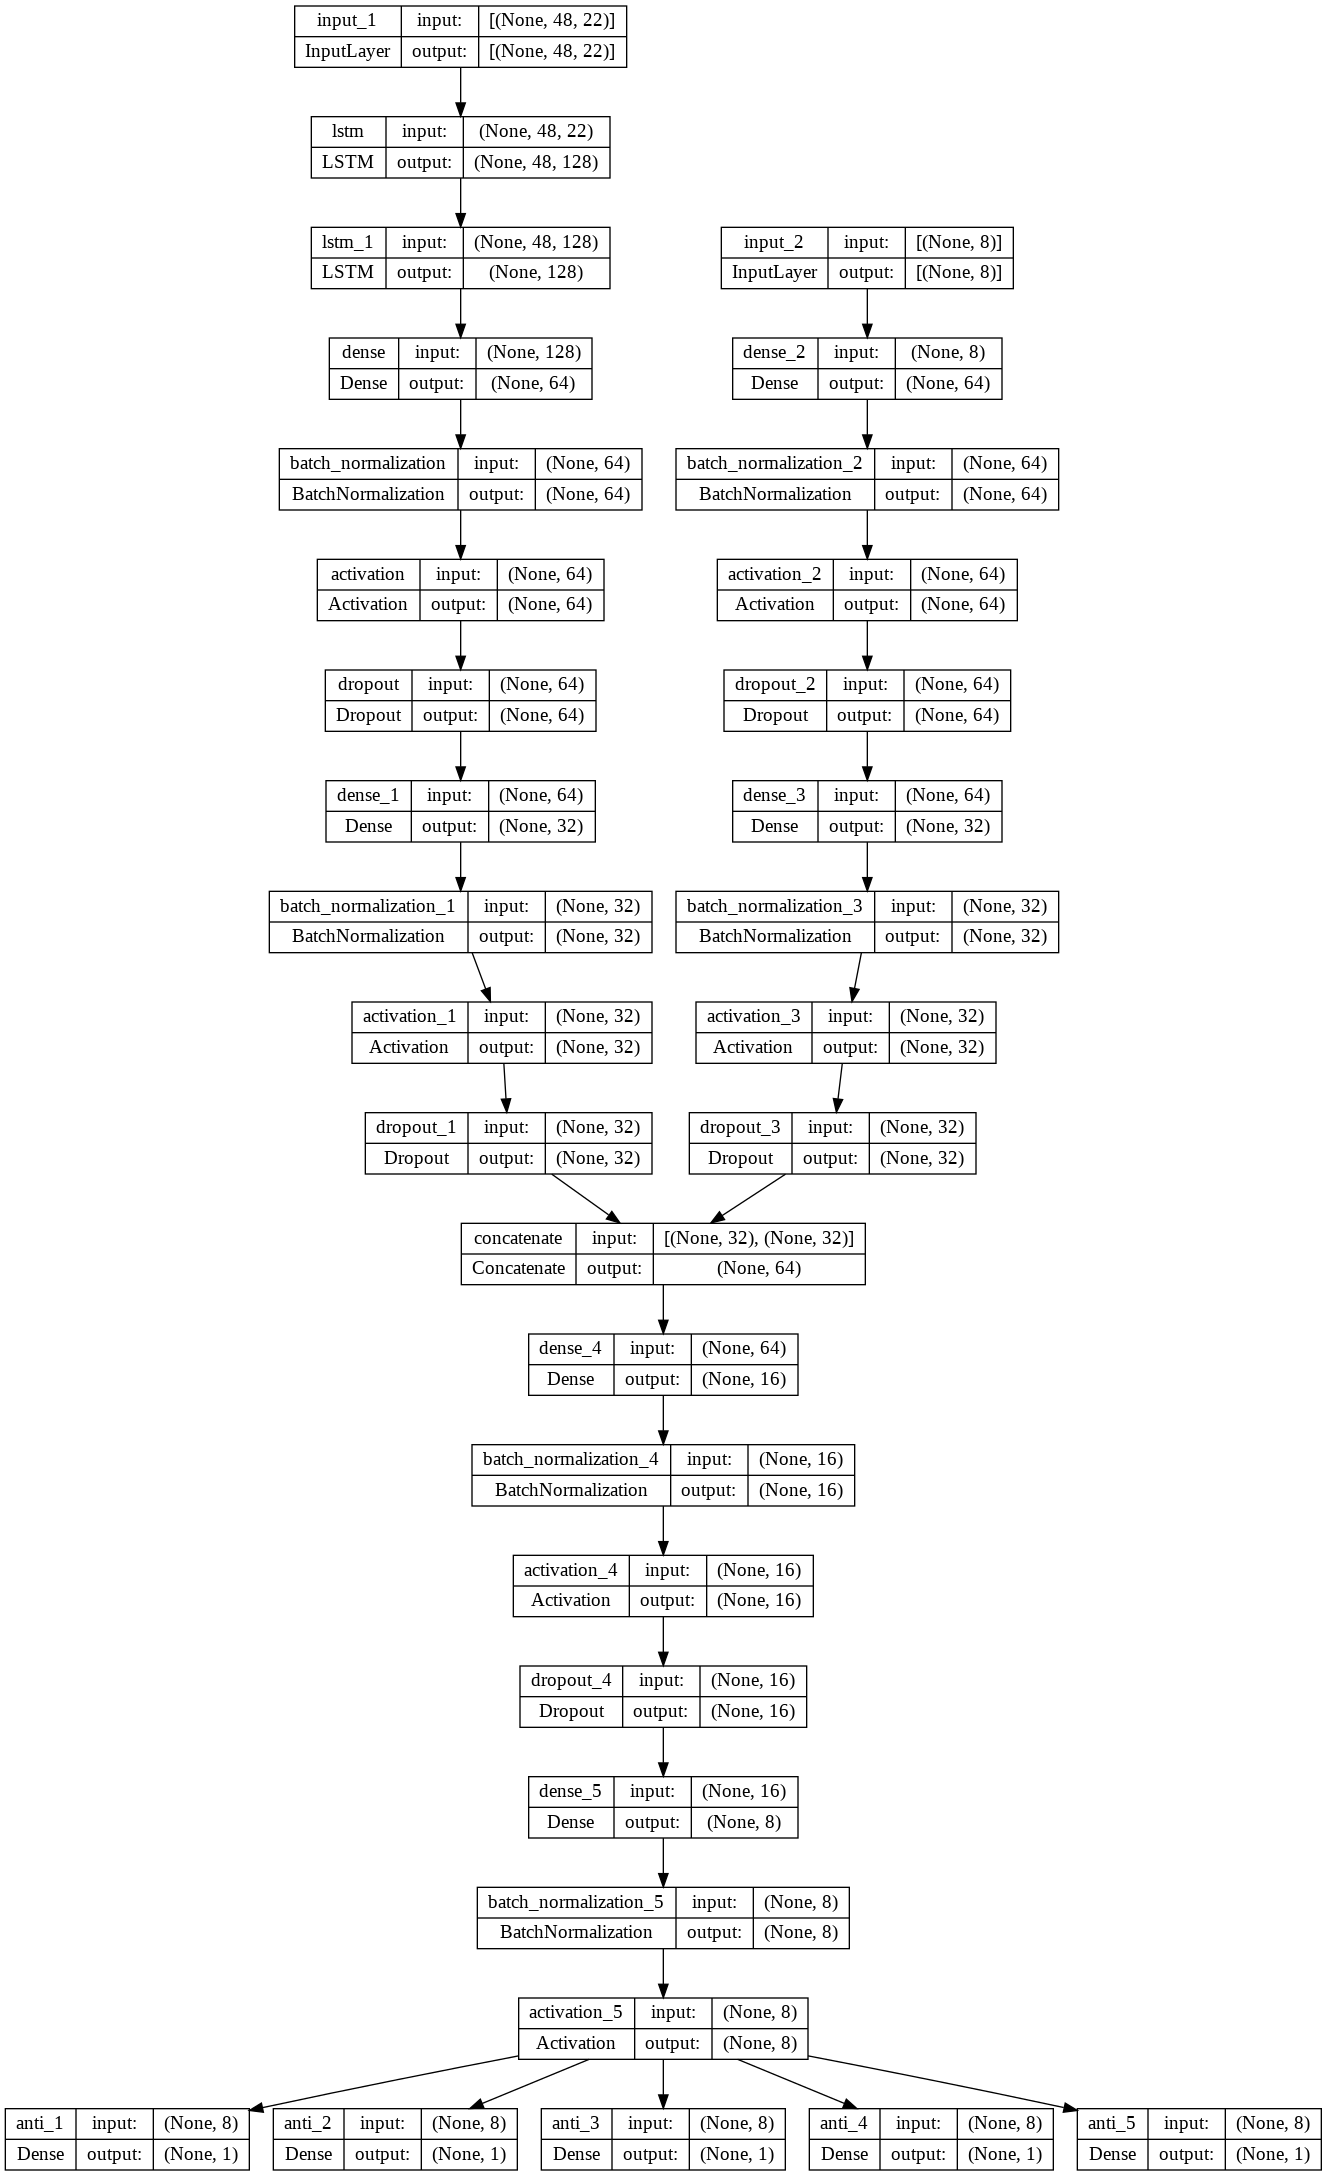

In [75]:
from keras.utils import plot_model
plot_model(model3, to_file='./model.png',show_shapes=True)

In [76]:
#callback = [tf.keras.callbacks.EarlyStopping(monitor='val_anti_1_auc', patience=20),
#            tf.keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/MyDrive/sepsis_model_weight/lstm_model/lstm_model_many.{epoch:02d}-{val_anti_1_auc:.3f}.h5',save_best_only=True)]

# callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100),
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
            tf.keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/MyDrive/sepsis_model_weight/anti_model/48_lstm_model_many.{epoch:02d}-{val_loss:.3f}.h5',save_best_only=True)]
            # tf.keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/MyDrive/sepsis_model_weight/lstm_model/lstm_model_many.{epoch:02d}-{val_loss:.3f}.h5',save_best_only=True)]

In [77]:
# history_lstm = model3.fit(anti_train_loader,validation_data=anti_test_loader,epochs=500,callbacks=callback,batch_size=64,verbose=2)
history_lstm = model3.fit(anti_train_loader,validation_data=anti_test_loader,epochs=500,callbacks=callback,verbose=2)

Epoch 1/500
405/405 - 22s - loss: 3.0101 - anti_1_loss: 0.6540 - anti_2_loss: 0.7036 - anti_3_loss: 0.6225 - anti_4_loss: 0.4737 - anti_5_loss: 0.5563 - anti_1_auc: 0.5444 - anti_2_auc_1: 0.5082 - anti_3_auc_2: 0.5107 - anti_4_auc_3: 0.5251 - anti_5_auc_4: 0.5084 - val_loss: 2.5852 - val_anti_1_loss: 0.6469 - val_anti_2_loss: 0.6803 - val_anti_3_loss: 0.5856 - val_anti_4_loss: 0.3886 - val_anti_5_loss: 0.2837 - val_anti_1_auc: 0.5668 - val_anti_2_auc_1: 0.4996 - val_anti_3_auc_2: 0.5337 - val_anti_4_auc_3: 0.5278 - val_anti_5_auc_4: 0.4995 - 22s/epoch - 54ms/step
Epoch 2/500
405/405 - 9s - loss: 2.4004 - anti_1_loss: 0.6156 - anti_2_loss: 0.6515 - anti_3_loss: 0.4901 - anti_4_loss: 0.3652 - anti_5_loss: 0.2780 - anti_1_auc: 0.6125 - anti_2_auc_1: 0.5255 - anti_3_auc_2: 0.5727 - anti_4_auc_3: 0.5360 - anti_5_auc_4: 0.5118 - val_loss: 4.6107 - val_anti_1_loss: 1.7663 - val_anti_2_loss: 0.9617 - val_anti_3_loss: 1.0215 - val_anti_4_loss: 0.6025 - val_anti_5_loss: 0.2586 - val_anti_1_auc: 

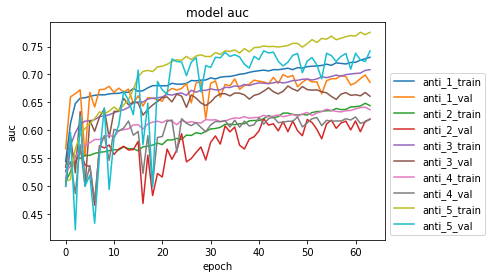

In [78]:
from matplotlib import pyplot as plt
plt.plot(history_lstm.history['anti_1_auc'])
plt.plot(history_lstm.history['val_anti_1_auc'])
plt.plot(history_lstm.history['anti_2_auc_1'])
plt.plot(history_lstm.history['val_anti_2_auc_1'])
plt.plot(history_lstm.history['anti_3_auc_2'])
plt.plot(history_lstm.history['val_anti_3_auc_2'])
plt.plot(history_lstm.history['anti_4_auc_3'])
plt.plot(history_lstm.history['val_anti_4_auc_3'])
plt.plot(history_lstm.history['anti_5_auc_4'])
plt.plot(history_lstm.history['val_anti_5_auc_4'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['anti_1_train', 'anti_1_val','anti_2_train', 'anti_2_val','anti_3_train', 'anti_3_val','anti_4_train', 'anti_4_val','anti_5_train', 'anti_5_val'], loc='lower left',bbox_to_anchor=(1, 0))
plt.show()

In [80]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score, confusion_matrix

%matplotlib inline
lstm_train_predicts_1, lstm_test_predicts_1 = list(), list()
lstm_train_predicts_2, lstm_test_predicts_2 = list(), list()
lstm_train_predicts_3, lstm_test_predicts_3 = list(), list()
lstm_train_predicts_4, lstm_test_predicts_4 = list(), list()
lstm_train_predicts_5, lstm_test_predicts_5 = list(), list()
lstm_train_labels_1, lstm_test_labels_1 = list(), list()
lstm_train_labels_2, lstm_test_labels_2 = list(), list()
lstm_train_labels_3, lstm_test_labels_3 = list(), list()
lstm_train_labels_4, lstm_test_labels_4 = list(), list()
lstm_train_labels_5, lstm_test_labels_5 = list(), list()

for tr_x, tr_y in anti_train_loader:
    batch_predict = model3.predict(tr_x)
    lstm_train_predicts_1.append(batch_predict[0])
    lstm_train_predicts_2.append(batch_predict[1])
    lstm_train_predicts_3.append(batch_predict[2])
    lstm_train_predicts_4.append(batch_predict[3])
    lstm_train_predicts_5.append(batch_predict[4])
    lstm_train_labels_1.append(tr_y[0])
    lstm_train_labels_2.append(tr_y[1])
    lstm_train_labels_3.append(tr_y[2])
    lstm_train_labels_4.append(tr_y[3])
    lstm_train_labels_5.append(tr_y[4])

for test_x, test_y in anti_test_loader:
    batch_predict = model3.predict(test_x)
    lstm_test_predicts_1.append(batch_predict[0])
    lstm_test_predicts_2.append(batch_predict[1])
    lstm_test_predicts_3.append(batch_predict[2])
    lstm_test_predicts_4.append(batch_predict[3])
    lstm_test_predicts_5.append(batch_predict[4])
    lstm_test_labels_1.append(test_y[0])
    lstm_test_labels_2.append(test_y[1])
    lstm_test_labels_3.append(test_y[2])
    lstm_test_labels_4.append(test_y[3])
    lstm_test_labels_5.append(test_y[4])

lstm_train_predicts_1 = np.concatenate(lstm_train_predicts_1).reshape(-1, 1)
lstm_train_predicts_2 = np.concatenate(lstm_train_predicts_2).reshape(-1, 1)
lstm_train_predicts_3 = np.concatenate(lstm_train_predicts_3).reshape(-1, 1)
lstm_train_predicts_4 = np.concatenate(lstm_train_predicts_4).reshape(-1, 1)
lstm_train_predicts_5 = np.concatenate(lstm_train_predicts_5).reshape(-1, 1)
lstm_train_labels_1 = np.concatenate(lstm_train_labels_1).astype('int')
lstm_train_labels_2 = np.concatenate(lstm_train_labels_2).astype('int')
lstm_train_labels_3 = np.concatenate(lstm_train_labels_3).astype('int')
lstm_train_labels_4 = np.concatenate(lstm_train_labels_4).astype('int')
lstm_train_labels_5 = np.concatenate(lstm_train_labels_5).astype('int')
lstm_test_predicts_1 = np.concatenate(lstm_test_predicts_1).reshape(-1, 1)
lstm_test_predicts_2 = np.concatenate(lstm_test_predicts_2).reshape(-1, 1)
lstm_test_predicts_3 = np.concatenate(lstm_test_predicts_3).reshape(-1, 1)
lstm_test_predicts_4 = np.concatenate(lstm_test_predicts_4).reshape(-1, 1)
lstm_test_predicts_5 = np.concatenate(lstm_test_predicts_5).reshape(-1, 1)
lstm_test_labels_1 = np.concatenate(lstm_test_labels_1).astype('int')
lstm_test_labels_2 = np.concatenate(lstm_test_labels_2).astype('int')
lstm_test_labels_3 = np.concatenate(lstm_test_labels_3).astype('int')
lstm_test_labels_4 = np.concatenate(lstm_test_labels_4).astype('int')
lstm_test_labels_5 = np.concatenate(lstm_test_labels_5).astype('int')

lstm_train_roc_x_1, lstm_train_roc_y_1, _ = roc_curve(lstm_train_labels_1, lstm_train_predicts_1)
lstm_train_roc_x_2, lstm_train_roc_y_2, _ = roc_curve(lstm_train_labels_2, lstm_train_predicts_2)
lstm_train_roc_x_3, lstm_train_roc_y_3, _ = roc_curve(lstm_train_labels_3, lstm_train_predicts_3)
lstm_train_roc_x_4, lstm_train_roc_y_4, _ = roc_curve(lstm_train_labels_4, lstm_train_predicts_4)
lstm_train_roc_x_5, lstm_train_roc_y_5, _ = roc_curve(lstm_train_labels_5, lstm_train_predicts_5)
lstm_train_auroc_1 = roc_auc_score(lstm_train_labels_1, lstm_train_predicts_1)
lstm_train_auroc_2 = roc_auc_score(lstm_train_labels_2, lstm_train_predicts_2)
lstm_train_auroc_3 = roc_auc_score(lstm_train_labels_3, lstm_train_predicts_3)
lstm_train_auroc_4 = roc_auc_score(lstm_train_labels_4, lstm_train_predicts_4)
lstm_train_auroc_5 = roc_auc_score(lstm_train_labels_5, lstm_train_predicts_5)
lstm_test_roc_x_1, lstm_test_roc_y_1, _ = roc_curve(lstm_test_labels_1, lstm_test_predicts_1)
lstm_test_roc_x_2, lstm_test_roc_y_2, _ = roc_curve(lstm_test_labels_2, lstm_test_predicts_2)
lstm_test_roc_x_3, lstm_test_roc_y_3, _ = roc_curve(lstm_test_labels_3, lstm_test_predicts_3)
lstm_test_roc_x_4, lstm_test_roc_y_4, _ = roc_curve(lstm_test_labels_4, lstm_test_predicts_4)
lstm_test_roc_x_5, lstm_test_roc_y_5, _ = roc_curve(lstm_test_labels_5, lstm_test_predicts_5)
lstm_test_auroc_1 = roc_auc_score(lstm_test_labels_1, lstm_test_predicts_1)
lstm_test_auroc_2 = roc_auc_score(lstm_test_labels_2, lstm_test_predicts_2)
lstm_test_auroc_3 = roc_auc_score(lstm_test_labels_3, lstm_test_predicts_3)
lstm_test_auroc_4 = roc_auc_score(lstm_test_labels_4, lstm_test_predicts_4)
lstm_test_auroc_5 = roc_auc_score(lstm_test_labels_5, lstm_test_predicts_5)

1/1 [==============================] - 0s 22ms/step


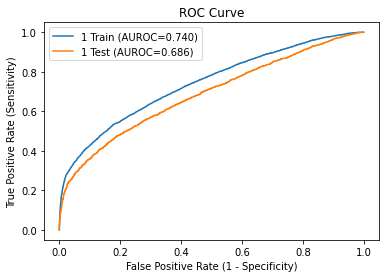

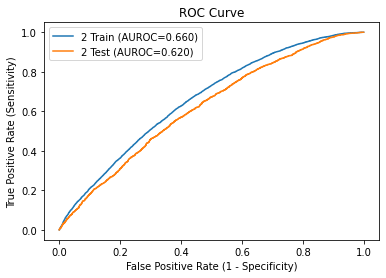

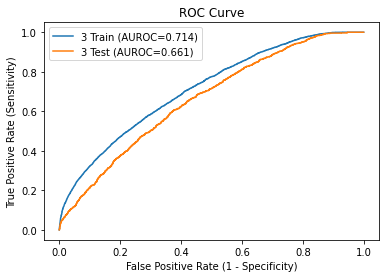

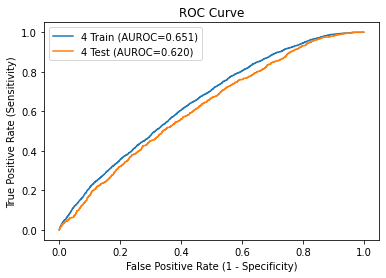

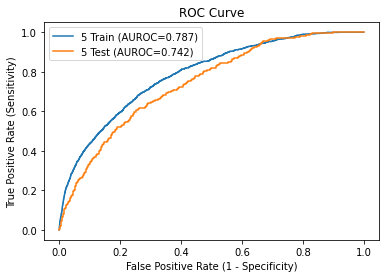

In [81]:
plt.figure()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')

plt.plot(lstm_train_roc_x_1, lstm_train_roc_y_1, linewidth=1.5, label='{} (AUROC={:.3f})'.format('1 Train', lstm_train_auroc_1))
plt.plot(lstm_test_roc_x_1, lstm_test_roc_y_1, linewidth=1.5, label='{} (AUROC={:.3f})'.format('1 Test', lstm_test_auroc_1))

plt.legend(fancybox=True)

plt.show()

plt.figure()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')

plt.plot(lstm_train_roc_x_2, lstm_train_roc_y_2, linewidth=1.5, label='{} (AUROC={:.3f})'.format('2 Train', lstm_train_auroc_2))
plt.plot(lstm_test_roc_x_2, lstm_test_roc_y_2, linewidth=1.5, label='{} (AUROC={:.3f})'.format('2 Test', lstm_test_auroc_2))

plt.legend(fancybox=True)

plt.show()

plt.figure()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')

plt.plot(lstm_train_roc_x_3, lstm_train_roc_y_3, linewidth=1.5, label='{} (AUROC={:.3f})'.format('3 Train', lstm_train_auroc_3))
plt.plot(lstm_test_roc_x_3, lstm_test_roc_y_3, linewidth=1.5, label='{} (AUROC={:.3f})'.format('3 Test', lstm_test_auroc_3))

plt.legend(fancybox=True)

plt.show()

plt.figure()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')

plt.plot(lstm_train_roc_x_4, lstm_train_roc_y_4, linewidth=1.5, label='{} (AUROC={:.3f})'.format('4 Train', lstm_train_auroc_4))
plt.plot(lstm_test_roc_x_4, lstm_test_roc_y_4, linewidth=1.5, label='{} (AUROC={:.3f})'.format('4 Test', lstm_test_auroc_4))

plt.legend(fancybox=True)

plt.show()


plt.figure()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')

plt.plot(lstm_train_roc_x_5, lstm_train_roc_y_5, linewidth=1.5, label='{} (AUROC={:.3f})'.format('5 Train', lstm_train_auroc_5))
plt.plot(lstm_test_roc_x_5, lstm_test_roc_y_5, linewidth=1.5, label='{} (AUROC={:.3f})'.format('5 Test', lstm_test_auroc_5))

plt.legend(fancybox=True)

plt.show()

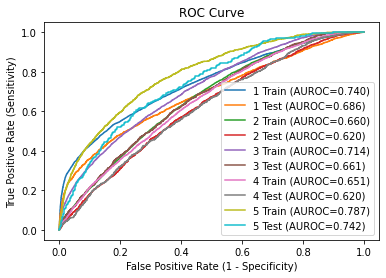

In [82]:
plt.figure()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')

plt.plot(lstm_train_roc_x_1, lstm_train_roc_y_1, linewidth=1.5, label='{} (AUROC={:.3f})'.format('1 Train', lstm_train_auroc_1))
plt.plot(lstm_test_roc_x_1, lstm_test_roc_y_1, linewidth=1.5, label='{} (AUROC={:.3f})'.format('1 Test', lstm_test_auroc_1))
plt.plot(lstm_train_roc_x_2, lstm_train_roc_y_2, linewidth=1.5, label='{} (AUROC={:.3f})'.format('2 Train', lstm_train_auroc_2))
plt.plot(lstm_test_roc_x_2, lstm_test_roc_y_2, linewidth=1.5, label='{} (AUROC={:.3f})'.format('2 Test', lstm_test_auroc_2))
plt.plot(lstm_train_roc_x_3, lstm_train_roc_y_3, linewidth=1.5, label='{} (AUROC={:.3f})'.format('3 Train', lstm_train_auroc_3))
plt.plot(lstm_test_roc_x_3, lstm_test_roc_y_3, linewidth=1.5, label='{} (AUROC={:.3f})'.format('3 Test', lstm_test_auroc_3))
plt.plot(lstm_train_roc_x_4, lstm_train_roc_y_4, linewidth=1.5, label='{} (AUROC={:.3f})'.format('4 Train', lstm_train_auroc_4))
plt.plot(lstm_test_roc_x_4, lstm_test_roc_y_4, linewidth=1.5, label='{} (AUROC={:.3f})'.format('4 Test', lstm_test_auroc_4))
plt.plot(lstm_train_roc_x_5, lstm_train_roc_y_5, linewidth=1.5, label='{} (AUROC={:.3f})'.format('5 Train', lstm_train_auroc_5))
plt.plot(lstm_test_roc_x_5, lstm_test_roc_y_5, linewidth=1.5, label='{} (AUROC={:.3f})'.format('5 Test', lstm_test_auroc_5))

plt.legend(fancybox=True)

plt.show()

In [83]:
print('{:.2f}, {:.2f}'.format(lstm_train_auroc_1, lstm_test_auroc_1))
print('{:.2f}, {:.2f}'.format(lstm_train_auroc_2, lstm_test_auroc_2))
print('{:.2f}, {:.2f}'.format(lstm_train_auroc_3, lstm_test_auroc_3))
print('{:.2f}, {:.2f}'.format(lstm_train_auroc_4, lstm_test_auroc_4))
print('{:.2f}, {:.2f}'.format(lstm_train_auroc_5, lstm_test_auroc_5))

0.74, 0.69
0.66, 0.62
0.71, 0.66
0.65, 0.62
0.79, 0.74


## 사망예측(항생제 예측 전이학습)-최종종

In [91]:
from keras import backend as k
k.clear_session()

In [92]:
base_model = keras.models.load_model('/content/gdrive/MyDrive/sepsis_model_weight/anti_model/48_lstm_model_many.44-2.189.h5')

In [86]:
! pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.7 MB/s 


In [93]:
def last_model():
    x = base_model(base_model.input,training=False)
    outs = layers.Dense(1, activation='sigmoid',name='death')(base_model.layers[-6].output)
    model = keras.Model(base_model.input, outs)
    model.compile(loss={'death':'binary_crossentropy'},metrics={'death':'AUC'})
  
    return model

model4=last_model()

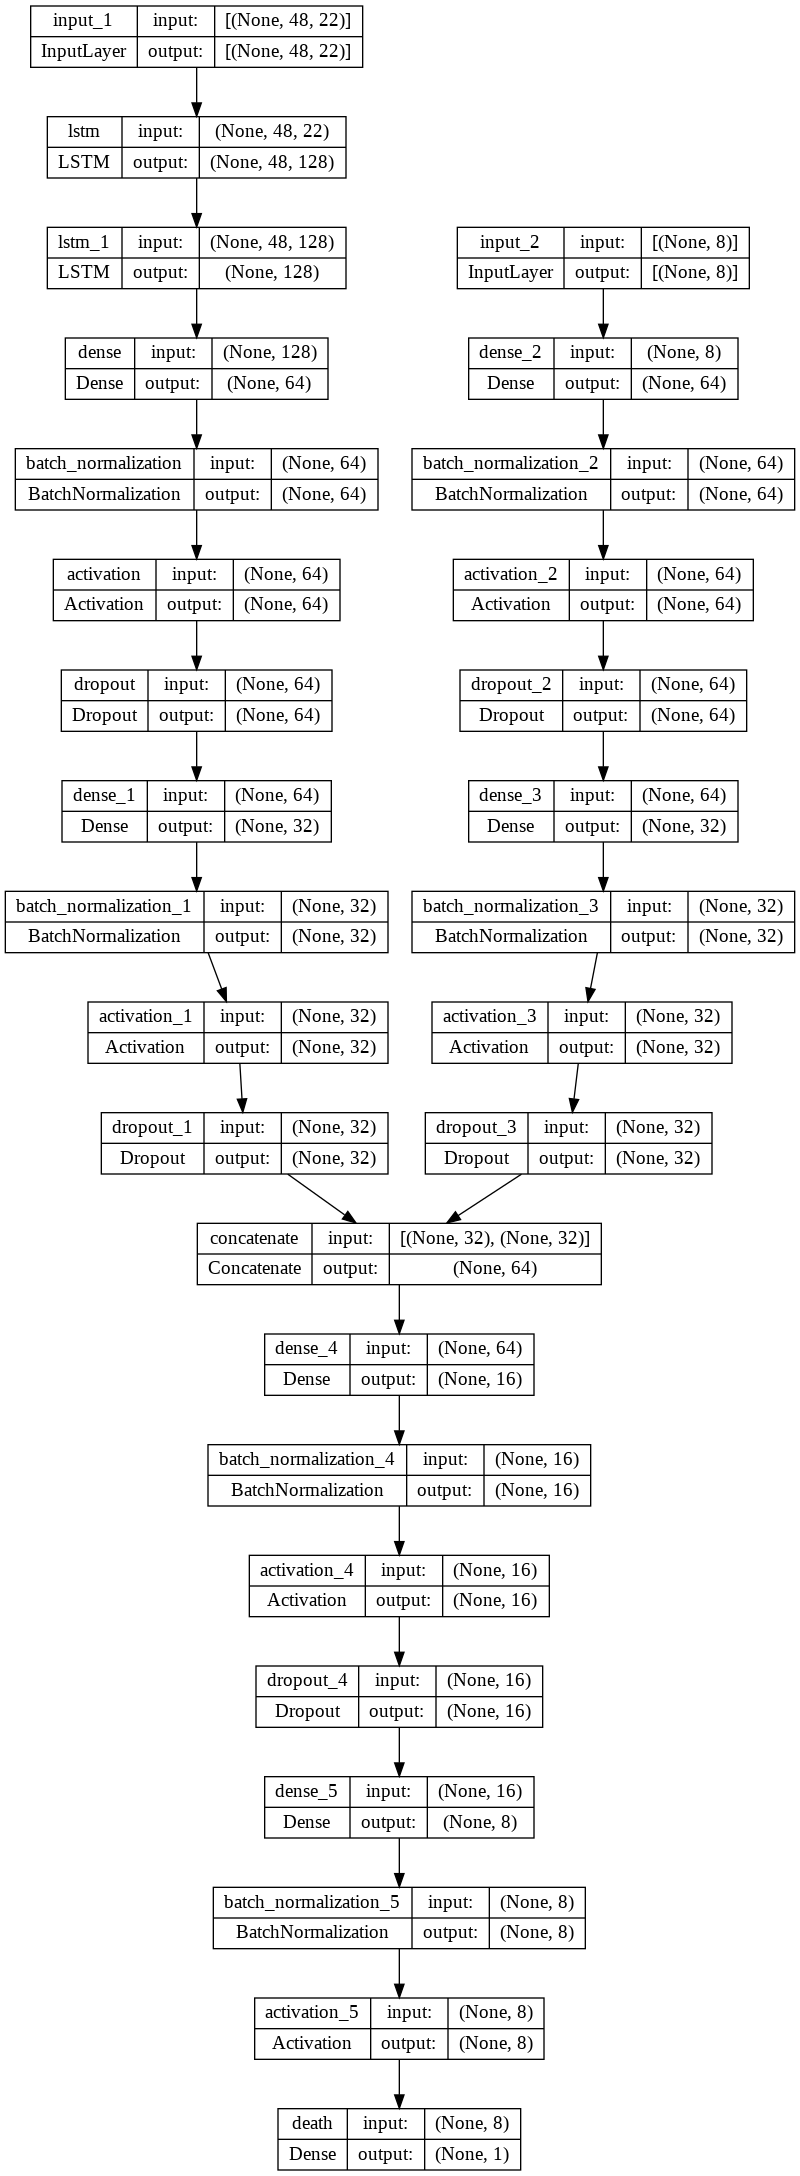

In [100]:
from keras.utils import plot_model
plot_model(model4, to_file='./model.png',show_shapes=True)

In [94]:
import tensorflow_addons as tfa
schedule1 = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00001,
    decay_steps=100000,
    decay_rate=0.96)
schedule2 = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=100000,
    decay_rate=0.96)
optimizers = [
    keras.optimizers.Adam(learning_rate=schedule1),
    keras.optimizers.Adam(learning_rate=schedule2)
]
optimizers_and_layers = [(optimizers[0], model4.layers[0:-1]), (optimizers[1], model4.layers[-1])]
optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

In [95]:
callback2 = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
            tf.keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/MyDrive/sepsis_model_weight/anti_model/48_lstm_model_last.{epoch:02d}-{val_loss:.3f}.h5',save_best_only=True)]

In [96]:
history_lstm_re = model4.fit(death_train_loader,validation_data=death_test_loader,epochs=500,callbacks=callback2,verbose=2)

Epoch 1/500
405/405 - 14s - loss: 0.3904 - auc: 0.7375 - val_loss: 0.3603 - val_auc: 0.7763 - 14s/epoch - 35ms/step
Epoch 2/500
405/405 - 7s - loss: 0.3494 - auc: 0.7862 - val_loss: 0.3625 - val_auc: 0.7860 - 7s/epoch - 18ms/step
Epoch 3/500
405/405 - 7s - loss: 0.3404 - auc: 0.8000 - val_loss: 0.3432 - val_auc: 0.8045 - 7s/epoch - 18ms/step
Epoch 4/500
405/405 - 7s - loss: 0.3418 - auc: 0.7995 - val_loss: 0.3410 - val_auc: 0.7986 - 7s/epoch - 18ms/step
Epoch 5/500
405/405 - 7s - loss: 0.3362 - auc: 0.8058 - val_loss: 0.3392 - val_auc: 0.8076 - 7s/epoch - 18ms/step
Epoch 6/500
405/405 - 7s - loss: 0.3307 - auc: 0.8157 - val_loss: 0.3409 - val_auc: 0.8065 - 7s/epoch - 18ms/step
Epoch 7/500
405/405 - 7s - loss: 0.3293 - auc: 0.8175 - val_loss: 0.3365 - val_auc: 0.8111 - 7s/epoch - 18ms/step
Epoch 8/500
405/405 - 7s - loss: 0.3272 - auc: 0.8191 - val_loss: 0.3458 - val_auc: 0.8078 - 7s/epoch - 18ms/step
Epoch 9/500
405/405 - 7s - loss: 0.3253 - auc: 0.8238 - val_loss: 0.3354 - val_auc: 0.

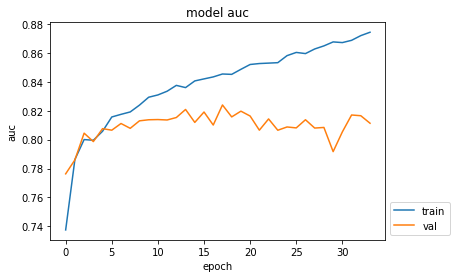

In [97]:
from matplotlib import pyplot as plt
plt.plot(history_lstm_re.history['auc'])
plt.plot(history_lstm_re.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left',bbox_to_anchor=(1, 0))
plt.show()

1/1 [==============================] - 0s 22ms/step


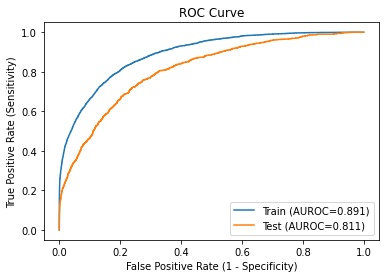

In [98]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score, confusion_matrix

%matplotlib inline
lstm_train_predicts, lstm_test_predicts = list(), list()
lstm_train_labels, lstm_test_labels = list(), list()

for tr_x, tr_y in death_train_loader:
    batch_predict = model4.predict(tr_x)
    lstm_train_predicts.append(batch_predict)
    lstm_train_labels.append(tr_y)

for test_x, test_y in death_test_loader:
    batch_predict = model4.predict(test_x)
    lstm_test_predicts.append(batch_predict)
    lstm_test_labels.append(test_y)

lstm_train_predicts = np.concatenate(lstm_train_predicts).reshape(-1, 1)
lstm_train_labels= np.array(np.concatenate(lstm_train_labels)).astype('int')
lstm_test_predicts = np.concatenate(lstm_test_predicts).reshape(-1, 1)
lstm_test_labels = np.array(np.concatenate(lstm_test_labels)).astype('int')
lstm_train_roc_x, lstm_train_roc_y, _ = roc_curve(lstm_train_labels, lstm_train_predicts)
lstm_train_auroc = roc_auc_score(lstm_train_labels, lstm_train_predicts)
lstm_test_roc_x, lstm_test_roc_y, _ = roc_curve(lstm_test_labels, lstm_test_predicts)
lstm_test_auroc = roc_auc_score(lstm_test_labels, lstm_test_predicts)
plt.figure()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')

plt.plot(lstm_train_roc_x, lstm_train_roc_y, linewidth=1.5, label='{} (AUROC={:.3f})'.format('Train', lstm_train_auroc))
plt.plot(lstm_test_roc_x, lstm_test_roc_y, linewidth=1.5, label='{} (AUROC={:.3f})'.format('Test', lstm_test_auroc))

plt.legend(fancybox=True)

plt.show()

In [99]:
print('{:.2f}, {:.2f}'.format(lstm_train_auroc, lstm_test_auroc))

0.89, 0.81


## 사망예측

In [126]:
from keras import backend as k
k.clear_session()

In [ ]:
#@title 사망 예측 모델 - 항생제와 비슷하게한 경우

from tensorflow.keras import optimizers

def death_model():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.LSTM(128,return_sequences=True)(input1)
  model1 = layers.LSTM(128)(model1)
  model1 = layers.Dense(64)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.1)(model1)
  model1 = layers.Dense(32)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.1)(model1)

  input2 = layers.Input(8)
  model2 = layers.Dense(64, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.1)(model2)
  model2 = layers.Dense(32, activation='relu')(model2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.1)(model2)

  model_add = layers.concatenate([model1, model2])  
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)
  model_add = layers.Dropout(0.1)(model_add)
  model_add = layers.Dense(8)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)

  outs = layers.Dense(1, activation='sigmoid',name='death')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=outs)
  schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=0.001,
      decay_steps=100000,
      decay_rate=0.96)
  opt = keras.optimizers.Adam(learning_rate=schedule)
  model.compile(optimizer = opt,loss={'death':'binary_crossentropy'},metrics={'death':'AUC'})
  
  return model

In [127]:
#@title 사망 예측 모델 - 심플한 버전

from tensorflow.keras import optimizers

def death_model():
  input1 = layers.Input(shape=(48,22))
  model1 = layers.LSTM(128)(input1)
  model1 = layers.Dense(64)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.1)(model1)
 
  input2 = layers.Input(8)
  model2 = layers.Dense(64, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.1)(model2)

  model_add = layers.concatenate([model1, model2])  
  model_add = layers.Dense(16)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)
  model_add = layers.Dropout(0.1)(model_add)
  
  outs = layers.Dense(1, activation='sigmoid',name='death')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=outs)
  schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=0.001,
      decay_steps=100000,
      decay_rate=0.96)
  opt = keras.optimizers.Adam(learning_rate=schedule)
  model.compile(optimizer = opt,loss={'death':'binary_crossentropy'},metrics={'death':'AUC'})
  
  return model

In [ ]:
#@title 사망 예측 모델 - 심플한 버전(2)

from tensorflow.keras import optimizers

def death_model():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.LSTM(16)(input1)
  model1 = layers.Dense(8)(model1)
  model1 = layers.BatchNormalization()(model1)
  model1 = layers.Activation('relu')(model1)
  model1 = layers.Dropout(0.1)(model1)
 
  input2 = layers.Input(8)
  model2 = layers.Dense(4, activation='relu')(input2)
  model2 = layers.BatchNormalization()(model2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.1)(model2)

  model_add = layers.concatenate([model1, model2])  
  model_add = layers.Dense(4)(model_add)
  model_add = layers.BatchNormalization()(model_add)
  model_add = layers.Activation('relu')(model_add)
  model_add = layers.Dropout(0.1)(model_add)
  
  outs = layers.Dense(1, activation='sigmoid',name='death')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=outs)
  schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=0.001,
      decay_steps=100000,
      decay_rate=0.96)
  opt = keras.optimizers.Adam(learning_rate=schedule)
  model.compile(optimizer = opt,loss={'death':'binary_crossentropy'},metrics={'death':'AUC'})
  
  return model

In [ ]:
#@title 사망 예측 모델 - 심플한 버전(3)
from tensorflow.keras import optimizers

def death_model():
  input1 = layers.Input(shape=(24,22))
  model1 = layers.LSTM(128)(input1)
  model1 = layers.Dense(64)(model1)
  model1 = layers.Activation('tanh')(model1)
  model1 = layers.Dropout(0.1)(model1)
 
  input2 = layers.Input(8)
  model2 = layers.Dense(64, activation='relu')(input2)
  model2 = layers.Activation('relu')(model2)
  model2 = layers.Dropout(0.1)(model2)

  model_add = layers.concatenate([model1, model2])  
  model_add = layers.Dense(32)(model_add)
  model_add = layers.Activation('relu')(model_add)
  model_add = layers.Dropout(0.1)(model_add)
  
  outs = layers.Dense(1, activation='sigmoid',name='death')(model_add)

  model = keras.Model(inputs=[input1, input2], outputs=outs)
  schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=0.01,
      decay_steps=100000,
      decay_rate=0.96)
  opt = keras.optimizers.Adam(learning_rate=schedule)
  model.compile(optimizer = opt,loss={'death':'binary_crossentropy'},metrics={'death':'AUC'})
  
  return model

In [128]:
model5 = death_model()

In [129]:
callback3 = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
            tf.keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/MyDrive/sepsis_model_weight/anti_model/48_death_model.{epoch:02d}-{val_loss:.3f}.h5',save_best_only=True)]

In [130]:
history_lstm_re = model5.fit(death_train_loader,validation_data=death_test_loader,epochs=500,callbacks=callback3,verbose=2)

Epoch 1/500
405/405 - 7s - loss: 0.4104 - auc: 0.7024 - val_loss: 0.3800 - val_auc: 0.7497 - 7s/epoch - 18ms/step
Epoch 2/500
405/405 - 4s - loss: 0.3572 - auc: 0.7699 - val_loss: 0.3722 - val_auc: 0.7608 - 4s/epoch - 10ms/step
Epoch 3/500
405/405 - 4s - loss: 0.3493 - auc: 0.7828 - val_loss: 0.3732 - val_auc: 0.7586 - 4s/epoch - 9ms/step
Epoch 4/500
405/405 - 4s - loss: 0.3431 - auc: 0.7954 - val_loss: 0.3551 - val_auc: 0.7905 - 4s/epoch - 10ms/step
Epoch 5/500
405/405 - 4s - loss: 0.3396 - auc: 0.8000 - val_loss: 0.3575 - val_auc: 0.7928 - 4s/epoch - 10ms/step
Epoch 6/500
405/405 - 4s - loss: 0.3375 - auc: 0.8037 - val_loss: 0.3383 - val_auc: 0.8028 - 4s/epoch - 10ms/step
Epoch 7/500
405/405 - 4s - loss: 0.3325 - auc: 0.8103 - val_loss: 0.3651 - val_auc: 0.7614 - 4s/epoch - 10ms/step
Epoch 8/500
405/405 - 4s - loss: 0.3319 - auc: 0.8123 - val_loss: 0.3381 - val_auc: 0.8097 - 4s/epoch - 10ms/step
Epoch 9/500
405/405 - 4s - loss: 0.3290 - auc: 0.8160 - val_loss: 0.3622 - val_auc: 0.800

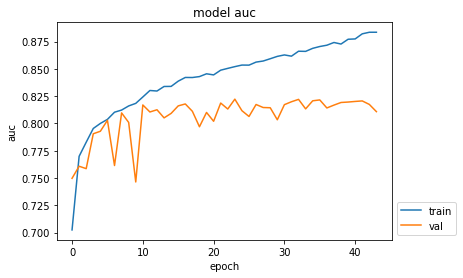

In [131]:
from matplotlib import pyplot as plt
plt.plot(history_lstm_re.history['auc'])
plt.plot(history_lstm_re.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left',bbox_to_anchor=(1, 0))
plt.show()

In [ ]:
# model5 = keras.models.load_model('/content/gdrive/MyDrive/sepsis_model_weight/anti_model/death_model.24-0.347.h5')
# model5 = keras.models.load_model('/content/gdrive/MyDrive/sepsis_model_weight/anti_model/death_model.34-0.346.h5')
# model5 = keras.models.load_model('/content/gdrive/MyDrive/sepsis_model_weight/anti_model/death_model.34-0.347.h5')

In [132]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score, confusion_matrix

%matplotlib inline
lstm_train_predicts, lstm_test_predicts = list(), list()
lstm_train_labels, lstm_test_labels = list(), list()

for tr_x, tr_y in death_train_loader:
    batch_predict = model5.predict(tr_x)
    lstm_train_predicts.append(batch_predict)
    lstm_train_labels.append(tr_y)

for test_x, test_y in death_test_loader:
    batch_predict = model5.predict(test_x)
    lstm_test_predicts.append(batch_predict)
    lstm_test_labels.append(test_y)

lstm_train_predicts = np.concatenate(lstm_train_predicts).reshape(-1, 1)
lstm_train_labels= np.array(np.concatenate(lstm_train_labels)).astype('int')
lstm_test_predicts = np.concatenate(lstm_test_predicts).reshape(-1, 1)
lstm_test_labels = np.array(np.concatenate(lstm_test_labels)).astype('int')
lstm_train_roc_x, lstm_train_roc_y, _ = roc_curve(lstm_train_labels, lstm_train_predicts)
lstm_train_auroc = roc_auc_score(lstm_train_labels, lstm_train_predicts)
lstm_test_roc_x, lstm_test_roc_y, _ = roc_curve(lstm_test_labels, lstm_test_predicts)
lstm_test_auroc = roc_auc_score(lstm_test_labels, lstm_test_predicts)

1/1 [==============================] - 0s 20ms/step


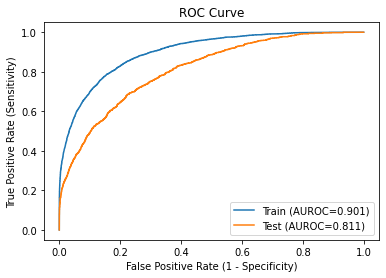

In [133]:
plt.figure()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')

plt.plot(lstm_train_roc_x, lstm_train_roc_y, linewidth=1.5, label='{} (AUROC={:.3f})'.format('Train', lstm_train_auroc))
plt.plot(lstm_test_roc_x, lstm_test_roc_y, linewidth=1.5, label='{} (AUROC={:.3f})'.format('Test', lstm_test_auroc))

plt.legend(fancybox=True)

plt.show()

In [134]:
print('{:.2f}, {:.2f}'.format(lstm_train_auroc, lstm_test_auroc))

0.90, 0.81


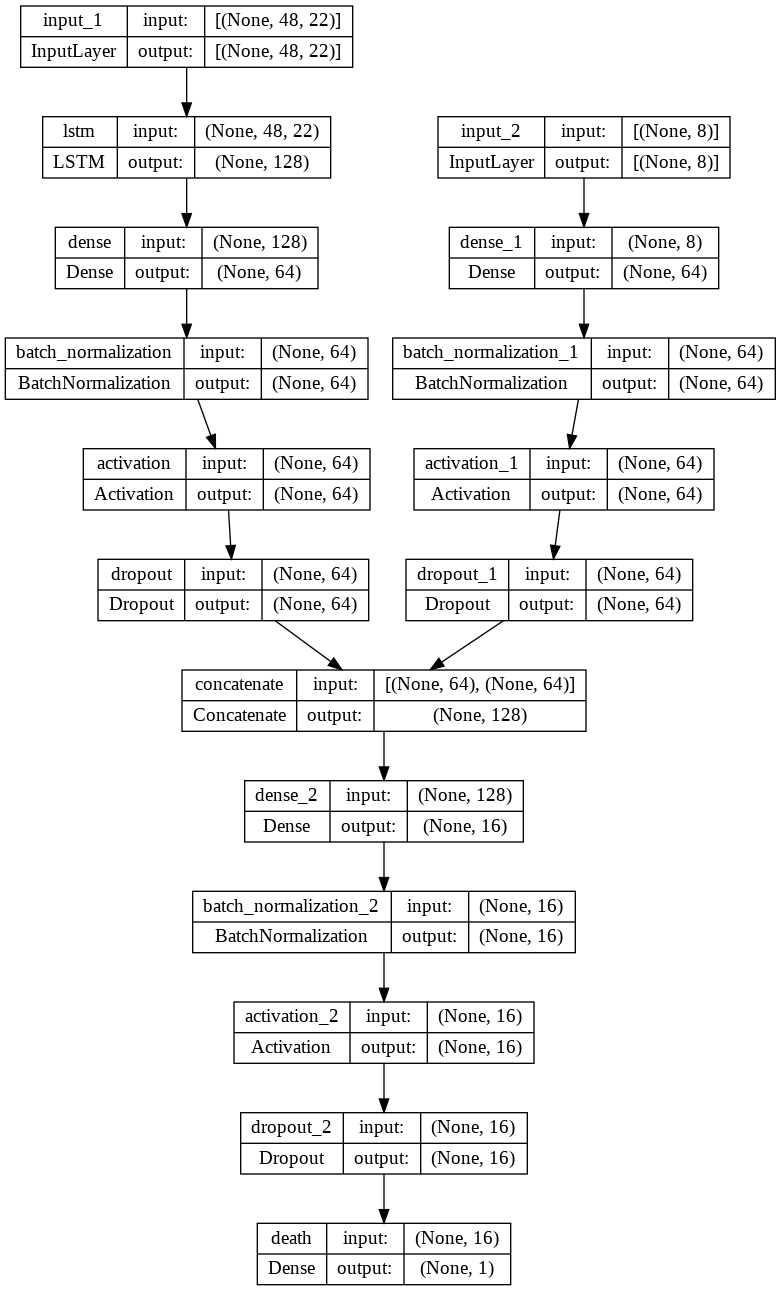

In [135]:
from keras.utils import plot_model
plot_model(model5, to_file='./model.png', show_shapes=True)

In [ ]:
#@title 2022.11.22 이전

# ## 사망예측 모델
# model1 = keras.Sequential([
#    layers.LSTM(16, input_shape=(13,16)),
#    layers.Dense(7, activation='relu')
# ])

# model2 = keras.Sequential([
#    layers.Dense(16, activation='relu',input_shape=[2])
# ])

# # death_lstm = layers.concatenate([model1, model2])
# # death_lstm = layers.Dense(1, activation="sigmoid")(death_lstm)

# # death_lstm = keras.Sequential()
# # death_lstm.add(layers.Merge([model1, model2], mode='concat', concat_axis=-1))

# # death_lstm = keras.Sequential()
# # death_lstm.add()([model1, model2])

# death_lstm = keras.Sequential(
#    layers.Concatenate([model1, model2]),
#    layers.Dense(1, activation='sigmoid')
# )
# # merge_f = layers.Concatenate(axis=-1)([rnn_f,demographic_dropout])
# death_lstm.summary()

# def lstm_model(tem_train, dem_train):
#     temporal_input_layer = Input(shape=(13 , 16))
#     main_rnn_layer = layers.LSTM(64, return_sequences=True)(temporal_input_layer) #recurrent_dropout=0.2
#     rnn_f = layers.LSTM(32)(main_rnn_layer)

#     demographic_input_layer = Input(shape=(2))
#     demographic_dense = layers.Dense(16)(demographic_input_layer)
#     demographic_dropout = layers.Dropout(0.2)(demographic_dense)

#     #fatality output branch
#     merge_f = layers.Concatenate(axis=-1)([rnn_f,demographic_dropout])
#     dense_f = layers.Dense(128)(merge_f)
#     dropout_f = layers.Dropout(0.2)(dense_f)
#     output = layers.Dense(1, activation='sigmoid', name="output")(dropout_f)

#     model = keras.Model([temporal_input_layer,demographic_input_layer], output)

#     model.summary()
#     return model

# ## 사망예측 모델
# model1 = keras.Sequential([
#    layers.LSTM(16, input_shape=(13,16)),
#    layers.Dense(7, activation='relu')
# ])

# model2 = keras.Sequential([
#    layers.Dense(16, activation='relu',input_shape=[2])
# ])

# # death_lstm = layers.concatenate([model1, model2])
# # death_lstm = layers.Dense(1, activation="sigmoid")(death_lstm)

# # death_lstm = keras.Sequential()
# # death_lstm.add(layers.Merge([model1, model2], mode='concat', concat_axis=-1))

# # death_lstm = keras.Sequential()
# # death_lstm.add()([model1, model2])

# death_lstm = keras.Sequential(
#    layers.Concatenate([model1, model2]),
#    layers.Dense(1, activation='sigmoid')
# )
# # merge_f = layers.Concatenate(axis=-1)([rnn_f,demographic_dropout])
# death_lstm.summary()

In [ ]:
#@title 동적변수 이전

## 사망예측 모델
#death_lstm = keras.Sequential([
#    layers.LSTM(25, input_shape=(13,16)),
#    layers.Dense(125, activation='relu'),
#    layers.Dense(1, activation='sigmoid')
#])
#death_lstm.summary()

## 사망예측 모델
#death_lstm = keras.Sequential([
#    layers.LSTM(25, input_shape=(13,16)),
#    layers.Dense(125),
#    layers.BatchNormalization(),
#    layers.Activation('relu'),
#    layers.Dropout(0.2),
#    #batch normalization, dropout,optimizer deat
#    layers.Dense(1, activation='sigmoid')
#])
#death_lstm.summary()

# ## 사망예측 모델
# death_lstm_re = keras.Sequential([
#     layers.LSTM(64, input_shape=(13,27), return_sequences=True),
#     layers.LSTM(64),
#     layers.Dense(32),
#     layers.BatchNormalization(),
#     layers.Activation('tanh'),
#     layers.Dropout(0.1),
#     layers.Dense(1, activation='sigmoid')
# ])
# death_lstm_re.summary()

# ## 사망예측 모델
# death_lstm_re = keras.Sequential([
#     layers.LSTM(16, input_shape=(13,27), return_sequences=True),
#     layers.LSTM(16, return_sequences=True),
#     layers.LSTM(16, return_sequences=True),
#     layers.LSTM(16),
#     layers.Dense(16),
#     layers.BatchNormalization(),
#     layers.Activation('tanh'),
#     layers.Dropout(0.1),
#     #batch normalization, dropout,optimizer deat
#     layers.Dense(1, activation='sigmoid')
# ])
# death_lstm_re.summary()

# ## 사망예측 모델
# death_lstm_re = keras.Sequential([
#     layers.LSTM(256, input_shape=(13,16), return_sequences=True),
#     layers.LSTM(256),
#     layers.Dense(128),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Dropout(0.2),
#     layers.Dense(128),  
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Dropout(0.2),
#     #batch normalization, dropout,optimizer deat
#     layers.Dense(1, activation='sigmoid')
# ])
# death_lstm_re.summary()

## 사망예측 모델
#death_lstm_re = keras.Sequential([
#    layers.LSTM(256, input_shape=(13,16), return_sequences=True),
#    layers.LSTM(256, return_sequences=True),
#    layers.LSTM(256),
#    layers.Dense(128),
#    layers.BatchNormalization(),
#    layers.Activation('relu'),
#    layers.Dropout(0.1),
#    layers.Dense(128),
#    layers.BatchNormalization(),
#    layers.Activation('relu'),
#    layers.Dropout(0.1),
#    #batch normalization, dropout,optimizer deat
#    layers.Dense(1, activation='sigmoid')
#])
#death_lstm_re.summary()

## 사망예측 모델 학습
# #death_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# #keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# adam = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
# #adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
# #adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-5, amsgrad=False)
# #adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-4, amsgrad=False)

# death_lstm_re.compile(loss='binary_crossentropy', optimizer=adam, metrics=['AUC'])

# #num_epochs = 100
# num_epochs = 70 
# #num_epochs = 200
# # history = death_lstm_re.fit(death_train_loader, validation_data=death_test_loader, epochs=num_epochs, verbose=2, validation_split=0.1)
# history = death_lstm_re.fit(death_train_loader, validation_data=death_test_loader, epochs=num_epochs, verbose=2, validation_split=0.1)

## 약제별 분석

In [ ]:
cepha_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

glyco_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

peni_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

fluoro_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

macro_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})
list_glyco=[]
for i in id_glyco['hadm_id']:
  list_glyco.append(i)

list_cepha=[]
for i in id_cepha['hadm_id']:
  list_cepha.append(i)

list_peni=[]
for i in id_peni['hadm_id']:
  list_peni.append(i)

list_fluoro=[]
for i in id_fluoro['hadm_id']:
  list_fluoro.append(i)

list_macro=[]
for i in id_macro['hadm_id']:
  list_macro.append(i)

for i in tqdm(range(len(death_dataset['HADM_IDS'])), desc='Make Glycopeptides Dataset', ncols = 700):
  if (death_dataset['HADM_IDS'][i] in list_glyco) == True:
      glyco_dataset['HADM_IDS'].append(death_dataset['HADM_IDS'][i])
      glyco_dataset['LABEL'].append(death_dataset['LABEL'][i])
      glyco_dataset['DATA'].append(death_dataset['DATA'][i])

for i in tqdm(range(len(death_dataset['HADM_IDS'])), desc='Make Cephalosporins Dataset', ncols = 700):
  if (death_dataset['HADM_IDS'][i] in list_cepha) == True:
      cepha_dataset['HADM_IDS'].append(death_dataset['HADM_IDS'][i])
      cepha_dataset['LABEL'].append(death_dataset['LABEL'][i])
      cepha_dataset['DATA'].append(death_dataset['DATA'][i])

for i in tqdm(range(len(death_dataset['HADM_IDS'])), desc='Make Penicillins Dataset', ncols = 700):
  if (death_dataset['HADM_IDS'][i] in list_peni) == True:
      peni_dataset['HADM_IDS'].append(death_dataset['HADM_IDS'][i])
      peni_dataset['LABEL'].append(death_dataset['LABEL'][i])
      peni_dataset['DATA'].append(death_dataset['DATA'][i])

for i in tqdm(range(len(death_dataset['HADM_IDS'])), desc='Make Fluoroquinolones Dataset', ncols = 700):
  if (death_dataset['HADM_IDS'][i] in list_fluoro) == True:
      fluoro_dataset['HADM_IDS'].append(death_dataset['HADM_IDS'][i])
      fluoro_dataset['LABEL'].append(death_dataset['LABEL'][i])
      fluoro_dataset['DATA'].append(death_dataset['DATA'][i])

for i in tqdm(range(len(death_dataset['HADM_IDS'])), desc='Make Macrolides Dataset', ncols = 700):
  if (death_dataset['HADM_IDS'][i] in list_macro) == True:
      macro_dataset['HADM_IDS'].append(death_dataset['HADM_IDS'][i])
      macro_dataset['LABEL'].append(death_dataset['LABEL'][i])
      macro_dataset['DATA'].append(death_dataset['DATA'][i])

print(len(glyco_dataset['HADM_IDS']))
print(len(cepha_dataset['HADM_IDS']))
print(len(peni_dataset['HADM_IDS']))
print(len(fluoro_dataset['HADM_IDS']))
print(len(macro_dataset['HADM_IDS']))

In [ ]:
glyco_lstm = keras.Sequential([
    layers.LSTM(25, input_shape=(13,16)),
    layers.Dense(125, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

cepha_lstm = keras.Sequential([
    layers.LSTM(25, input_shape=(13,16)),
    layers.Dense(125, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

peni_lstm = keras.Sequential([
    layers.LSTM(25, input_shape=(13,16)),
    layers.Dense(125, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

fluoro_lstm = keras.Sequential([
    layers.LSTM(25, input_shape=(13,16)),
    layers.Dense(125, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

macro_lstm = keras.Sequential([
    layers.LSTM(25, input_shape=(13,16)),
    layers.Dense(125, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
#@title 약제별 분석


glyco_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 100
history = glyco_lstm.fit(glyco_train_loader, validation_data=glyco_test_loader, epochs=num_epochs, verbose=2)


cepha_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 100
history = cepha_lstm.fit(cepha_train_loader, validation_data=cepha_test_loader, epochs=num_epochs, verbose=2)


peni_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 100
history = peni_lstm.fit(peni_train_loader, validation_data=peni_test_loader, epochs=num_epochs, verbose=2)

fluoro_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 100
history = fluoro_lstm.fit(fluoro_train_loader, validation_data=fluoro_test_loader, epochs=num_epochs, verbose=2)

macro_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 100
history = macro_lstm.fit(macro_train_loader, validation_data=macro_test_loader, epochs=num_epochs, verbose=2)

In [ ]:
glyco_lstm.save('/content/gdrive/MyDrive/sepsis_model_weight/model_glyco.h5')
cepha_lstm.save('/content/gdrive/MyDrive/sepsis_model_weight/model_cepha.h5')
peni_lstm.save('/content/gdrive/MyDrive/sepsis_model_weight/model_peni.h5')
fluoro_lstm.save('/content/gdrive/MyDrive/sepsis_model_weight/model_fluoro.h5')
macro_lstm.save('/content/gdrive/MyDrive/sepsis_model_weight/model_macro.h5')

In [ ]:
glyco_label=pd.DataFrame(glyco_test['LABEL'])

death_predict=pd.DataFrame(death_lstm.predict(glyco_test_loader))
glyco_predict=pd.DataFrame(glyco_lstm.predict(glyco_test_loader))
cepha_predict=pd.DataFrame(cepha_lstm.predict(glyco_test_loader))
peni_predict=pd.DataFrame(peni_lstm.predict(glyco_test_loader))
fluoro_predict=pd.DataFrame(fluoro_lstm.predict(glyco_test_loader))
macro_predict=pd.DataFrame(macro_lstm.predict(glyco_test_loader))

19/19 [==============================] - 0s 4ms/step


In [ ]:
glyco_total=pd.concat([glyco_label,death_predict,glyco_predict,cepha_predict,peni_predict,fluoro_predict,macro_predict],axis=1)
glyco_total.columns=['label','death_model','glyco_model','cepha_model','peni_model','fluoro_model','macro_model']

In [ ]:
glyco_total

,label,death_model,glyco_model,cepha_model,peni_model,fluoro_model,macro_model
0,1,0.014108,0.223974,0.092540,0.349622,0.311748,0.180778
1,1,0.485061,0.470382,0.522545,0.205113,0.142648,0.128929
2,1,0.356203,0.426065,0.678691,0.231644,0.217998,0.113417
3,1,0.195743,0.163080,0.122726,0.144958,0.110240,0.103486
4,1,0.193229,0.137318,0.205912,0.104218,0.109623,0.064443
...,...,...,...,...,...,...,...
2347,0,0.157966,0.136068,0.127145,0.076348,0.094608,0.062250
2348,0,0.152380,0.152679,0.114211,0.131388,0.103832,0.099097
2349,0,0.262742,0.167690,0.180576,0.158227,0.145779,0.119568
2350,0,0.186726,0.192592,0.222549,0.164990,0.206763,0.104039


In [ ]:
glyco_total.to_csv('glyco_total.csv')

In [ ]:
glyco_total.describe()

,label,death_model,glyco_model,cepha_model,peni_model,fluoro_model,macro_model
count,2352.000000,2352.000000,2352.000000,2352.000000,2352.000000,2352.000000,2352.000000
mean,0.215986,0.196350,0.214887,0.186830,0.198750,0.176921,0.142387
std,0.411592,0.170452,0.158309,0.153455,0.152484,0.155931,0.126896
min,0.000000,0.001662,0.015854,0.000040,0.003022,0.043336,0.002842
25%,0.000000,0.106631,0.149175,0.122726,0.139193,0.108697,0.096551
50%,0.000000,0.164574,0.163080,0.135749,0.144958,0.112443,0.103486
75%,0.000000,0.195743,0.181829,0.198761,0.177399,0.180022,0.125479
max,1.000000,0.999955,0.999038,0.994983,0.988274,0.999859,0.991618


In [ ]:
cepha_label=pd.DataFrame(cepha_test['LABEL'])

death_predict=pd.DataFrame(death_lstm.predict(cepha_test_loader))
glyco_predict=pd.DataFrame(glyco_lstm.predict(cepha_test_loader))
cepha_predict=pd.DataFrame(cepha_lstm.predict(cepha_test_loader))
peni_predict=pd.DataFrame(peni_lstm.predict(cepha_test_loader))
fluoro_predict=pd.DataFrame(fluoro_lstm.predict(cepha_test_loader))
macro_predict=pd.DataFrame(macro_lstm.predict(cepha_test_loader))

18/18 [==============================] - 0s 4ms/step


In [ ]:
cepha_total=pd.concat([cepha_label,death_predict,glyco_predict,cepha_predict,peni_predict,fluoro_predict,macro_predict],axis=1)
cepha_total.columns=['label','death_model','glyco_model','cepha_model','peni_model','fluoro_model','macro_model']

In [ ]:
cepha_total

,label,death_model,glyco_model,cepha_model,peni_model,fluoro_model,macro_model
0,1,0.236570,0.148248,0.279651,0.132168,0.122248,0.086393
1,1,0.410458,0.297525,0.233613,0.239752,0.316624,0.117778
2,1,0.999856,0.895030,0.984093,0.980664,0.999827,0.656816
3,1,0.195743,0.163080,0.122726,0.144958,0.110240,0.103486
4,1,0.237204,0.201668,0.251227,0.167174,0.294863,0.145911
...,...,...,...,...,...,...,...
2187,0,0.077487,0.146791,0.097477,0.153996,0.095492,0.111025
2188,0,0.263328,0.408858,0.108774,0.162515,0.205582,0.099497
2189,0,0.195743,0.163080,0.122726,0.144958,0.110240,0.103486
2190,0,0.195743,0.163080,0.122726,0.144958,0.110240,0.103486


In [ ]:
cepha_total.describe()

,label,death_model,glyco_model,cepha_model,peni_model,fluoro_model,macro_model
count,2192.000000,2192.000000,2192.000000,2192.000000,2192.000000,2192.000000,2192.000000
mean,0.148266,0.153331,0.193897,0.146789,0.186245,0.165484,0.136834
std,0.355445,0.141966,0.128466,0.128426,0.124085,0.127099,0.117513
min,0.000000,0.004505,0.014203,0.000041,0.003430,0.041863,0.002022
25%,0.000000,0.071000,0.145172,0.085396,0.136709,0.108039,0.091566
50%,0.000000,0.128333,0.163080,0.122726,0.144958,0.115422,0.103486
75%,0.000000,0.195743,0.174878,0.166112,0.178013,0.180804,0.127038
max,1.000000,0.999952,0.998940,0.993771,0.988274,0.999858,0.989579


In [ ]:
peni_label=pd.DataFrame(peni_test['LABEL'])

death_predict=pd.DataFrame(death_lstm.predict(peni_test_loader))
glyco_predict=pd.DataFrame(glyco_lstm.predict(peni_test_loader))
cepha_predict=pd.DataFrame(cepha_lstm.predict(peni_test_loader))
peni_predict=pd.DataFrame(peni_lstm.predict(peni_test_loader))
fluoro_predict=pd.DataFrame(fluoro_lstm.predict(peni_test_loader))
macro_predict=pd.DataFrame(macro_lstm.predict(peni_test_loader))

10/10 [==============================] - 0s 4ms/step


In [ ]:
peni_total=pd.concat([peni_label,death_predict,glyco_predict,cepha_predict,peni_predict,fluoro_predict,macro_predict],axis=1)
peni_total.columns=['label','death_model','glyco_model','cepha_model','peni_model','fluoro_model','macro_model']

In [ ]:
peni_total.describe()

,label,death_model,glyco_model,cepha_model,peni_model,fluoro_model,macro_model
count,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000
mean,0.206101,0.185862,0.207560,0.182194,0.188175,0.174800,0.137230
std,0.404670,0.161580,0.148215,0.141028,0.136850,0.147643,0.122632
min,0.000000,0.006523,0.013199,0.000043,0.000992,0.032825,0.001846
25%,0.000000,0.100963,0.147211,0.122726,0.134231,0.107627,0.092442
50%,0.000000,0.141116,0.163080,0.138982,0.144958,0.117527,0.103486
75%,0.000000,0.195743,0.182099,0.195352,0.174253,0.183134,0.127393
max,1.000000,0.999936,0.998780,0.994983,0.988192,0.999842,0.994304


In [ ]:
cepha_total.to_csv('glyco_total.csv')

In [ ]:
diagnoses_icd = pd.merge(left = diagnoses_icd, right = sepsis[['subject_id','sepsis3']], how='inner', left_on='subject_id', right_on='subject_id')

In [ ]:
sum(death_train['LABEL'])/len(death_train['LABEL'])

0.15838639569908872

모델 저장과
test data로 test( 5개 모델간 차이가 있는지)